<a href="https://colab.research.google.com/github/muhammadnashruddinnurarifbudiman/UAS_Data_Analytic/blob/main/Store_Customer_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mecoba mengklaser customer pada sebuah tempat perbelanjaan (20101292)

Import Library dan Dataset

In [ ]:
pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Downloading the necesary libraries
!pip install proplot

# Importing the necesary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from keras.layers import Embedding
import proplot as pplt
from kmodes.kprototypes import KPrototypes
import plotly.express as px

import warnings
warnings.filterwarnings('ignore') 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Data Preprocessing

In [ ]:
# Do we have missing values? / Mengecek nilai null

df.isnull().sum().sort_values(ascending=False).head()   

Income               24
ID                    0
NumDealsPurchases     0
Z_Revenue             0
Z_CostContact         0
dtype: int64

In [ ]:
# Imputing missing values with mean / mengisi nilai dengan mean

df.loc[(df['Income'].isnull() == True), 'Income'] = df['Income'].mean()   

In [ ]:
#Menambah variabel baru

df['Kids'] = df['Kidhome'] + df['Teenhome']
df['Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

In [ ]:
#Membersihkan beberapa variabel

#Check the types of marital status / Cek status pernikahan
df['Marital_Status'].value_counts()

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [ ]:
# Renaming categories / Mengganti nama kategori
df['Marital_Status'] = df['Marital_Status'].str.replace('Married', 'In relationship')
df['Marital_Status'] = df['Marital_Status'].str.replace('Together', 'In relationship')
df['Marital_Status'] = df['Marital_Status'].str.replace('Divorced', 'Single')
df['Marital_Status'] = df['Marital_Status'].str.replace('Widow', 'Single')
df['Marital_Status'] = df['Marital_Status'].str.replace('Absurd', 'Single')
df['Marital_Status'] = df['Marital_Status'].str.replace('Alone', 'Single')
df['Marital_Status'] = df['Marital_Status'].str.replace('YOLO', 'Single')

In [ ]:
# Check the types of marital status / Cek kembali status pernikahan
df['Education'].value_counts()  

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

In [ ]:
# 2n Cycle = Master (Bologna Process) / Menyamakan kategori 2n Cycle dengan Master
df['Education'] = df['Education'].str.replace('2n Cycle', 'Master')   

In [ ]:
# Customer's time being enrolled / Enroll data waktu customer
df['Dt_Customer'] = pd.to_datetime(df.Dt_Customer)
df['Date_Collected'] = '01-01-2015'
df['Date_Collected'] = pd.to_datetime(df.Date_Collected)
df['Time_Enrolled_Days'] = (df['Date_Collected'] - df['Dt_Customer']).dt.days

In [ ]:
df.columns   # Columns names

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Kids', 'Expenses', 'Date_Collected', 'Time_Enrolled_Days'],
      dtype='object')

In [ ]:
#Removing some variables / Menghapus beberapa variabel
df = df.drop(columns=[
       'ID', 'Dt_Customer', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases', 
       'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Date_Collected'
       ])

In [ ]:
# Rename the columns / Mengganti nama kolom
df.columns = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet', 'Gold', 'Children', 'Expenses', 'Time_Enrolled_Days']

In [ ]:
df.describe()

,Year_Birth,Income,Wines,Fruits,Meat,Fish,Sweet,Gold,Children,Expenses,Time_Enrolled_Days
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1968.805804,52247.251354,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,0.950446,605.798214,538.043304
std,11.984069,25037.797168,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,0.751803,602.249288,232.229893
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,26.000000
25%,1959.000000,35538.750000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,0.000000,68.750000,366.750000
50%,1970.000000,51741.500000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,1.000000,396.000000,539.000000
75%,1977.000000,68289.750000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,1.000000,1045.500000,711.250000
max,1996.000000,666666.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,3.000000,2525.000000,1089.000000


In [ ]:
# Removing outliers in income
from scipy import stats

df1 = df[(np.abs(stats.zscore(df['Income'])) < 3)]     # Remove observation with more than 3 in Standard Desviation
df1.reset_index(inplace=True)                          # Reset index
df1 = df1.drop(columns=['index'])   

In [ ]:
df_final = df1.copy()

# Standardization
for i in df_final.select_dtypes(exclude='object').columns:
    df_final.loc[:, i] = StandardScaler().fit_transform(np.array(df_final[[i]]))

Modeling Cluster

Clustering using K-Prototypes

In [ ]:
#Choosing optimal K
K = range(1,15)
cost = []
for k in K:
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    kproto.fit_predict(df_final, categorical=[1,2])
    cost.append(kproto.cost_)

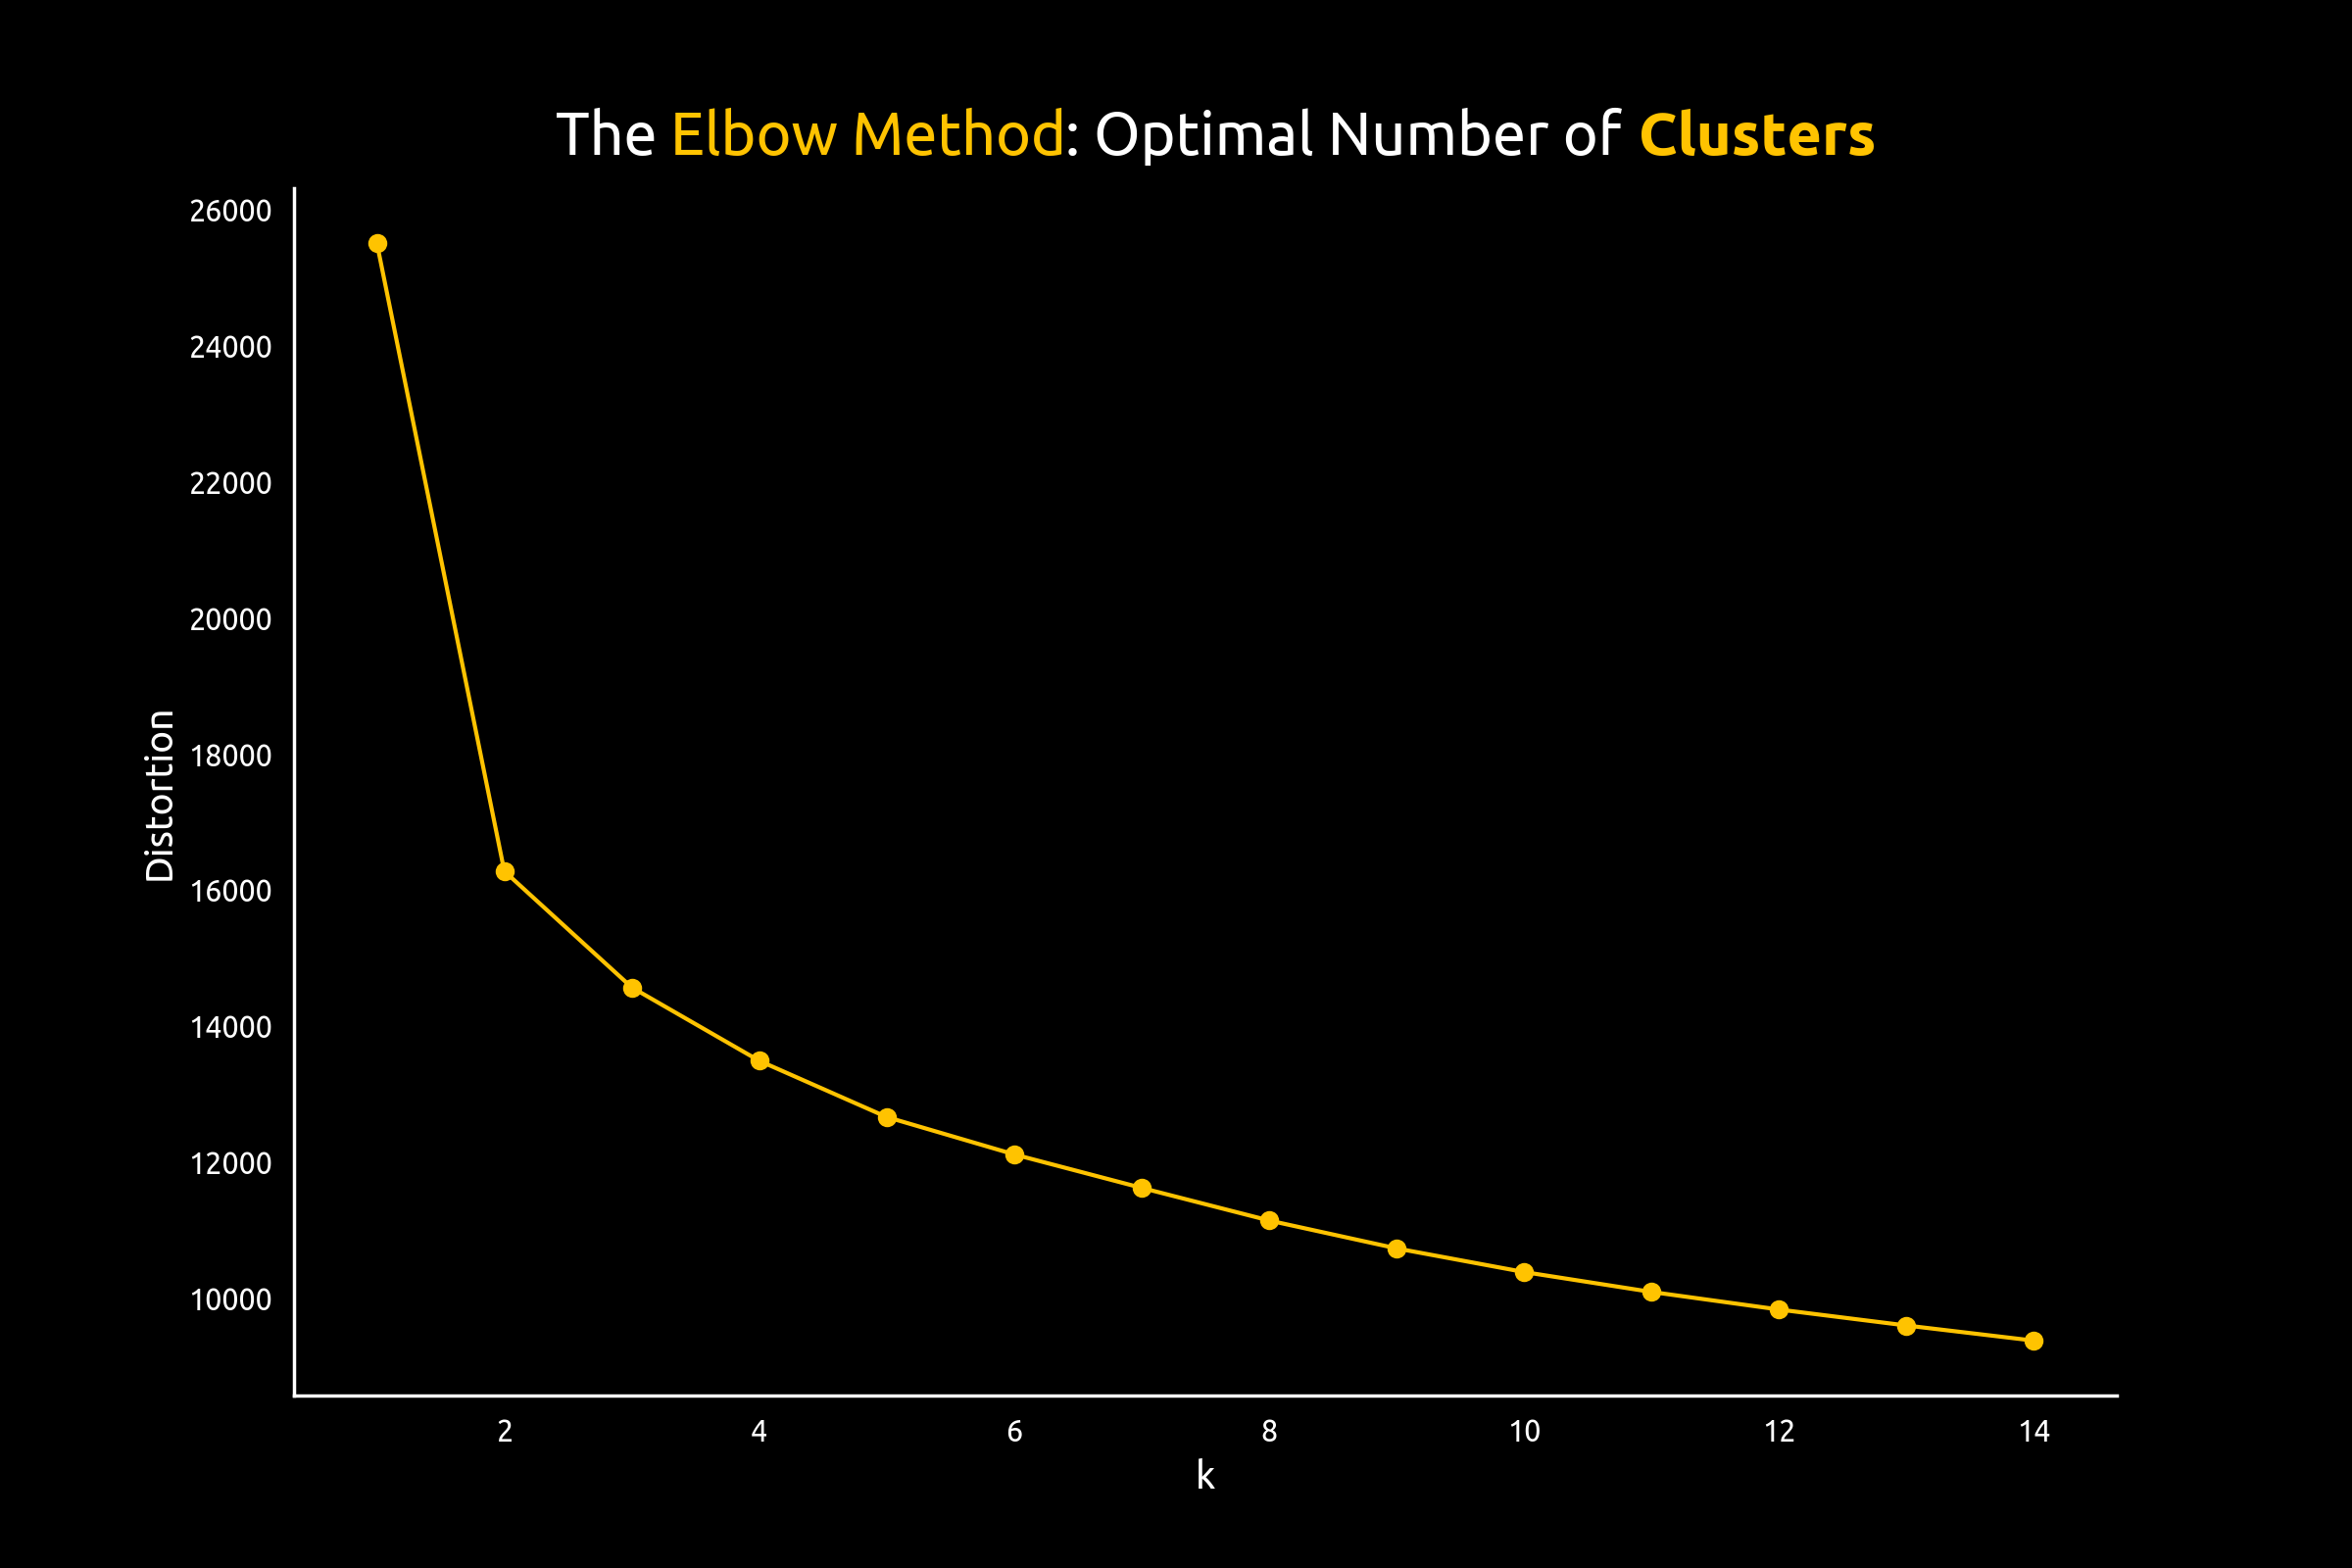

In [ ]:
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'font.family': 'Ubuntu'})

fig, ax = plt.subplots(figsize =(12, 8))

plt.plot(K, cost, 'bo-', color = '#FFC300')
plt.xlabel('k', color = 'white', size = 14)
plt.ylabel('Distortion', color = 'white', size = 14)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.text(2.4, 26800, "The", size=22, color="white")
plt.text(3.3, 26800,"Elbow Method", size=22, color="#FFC300")
plt.text(6.4, 26800, ": Optimal Number of", size=22, color="white")
plt.text(67000,2750,"Expenses", size=22, color="#FFC300")
#plt.text(120000, -350, "@miguelfzzz", fontsize=12, ha="right", color='lightgray', fontweight="bold")
plt.text(10.9, 26800, "Clusters", size=22, color="#FFC300", fontweight="bold")
#plt.text(14.65, 6900, "@miguelfzzz", fontsize=12, ha="right", color='lightgray', fontweight="bold")


plt.show()

In [ ]:
# Clustering
kproto = KPrototypes(n_clusters= 4, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(df_final, categorical=[1,2])

In [ ]:
# Merging original data with clusters
df_clusters = pd.concat([df1, pd.DataFrame({'cluster': clusters})], axis=1)   

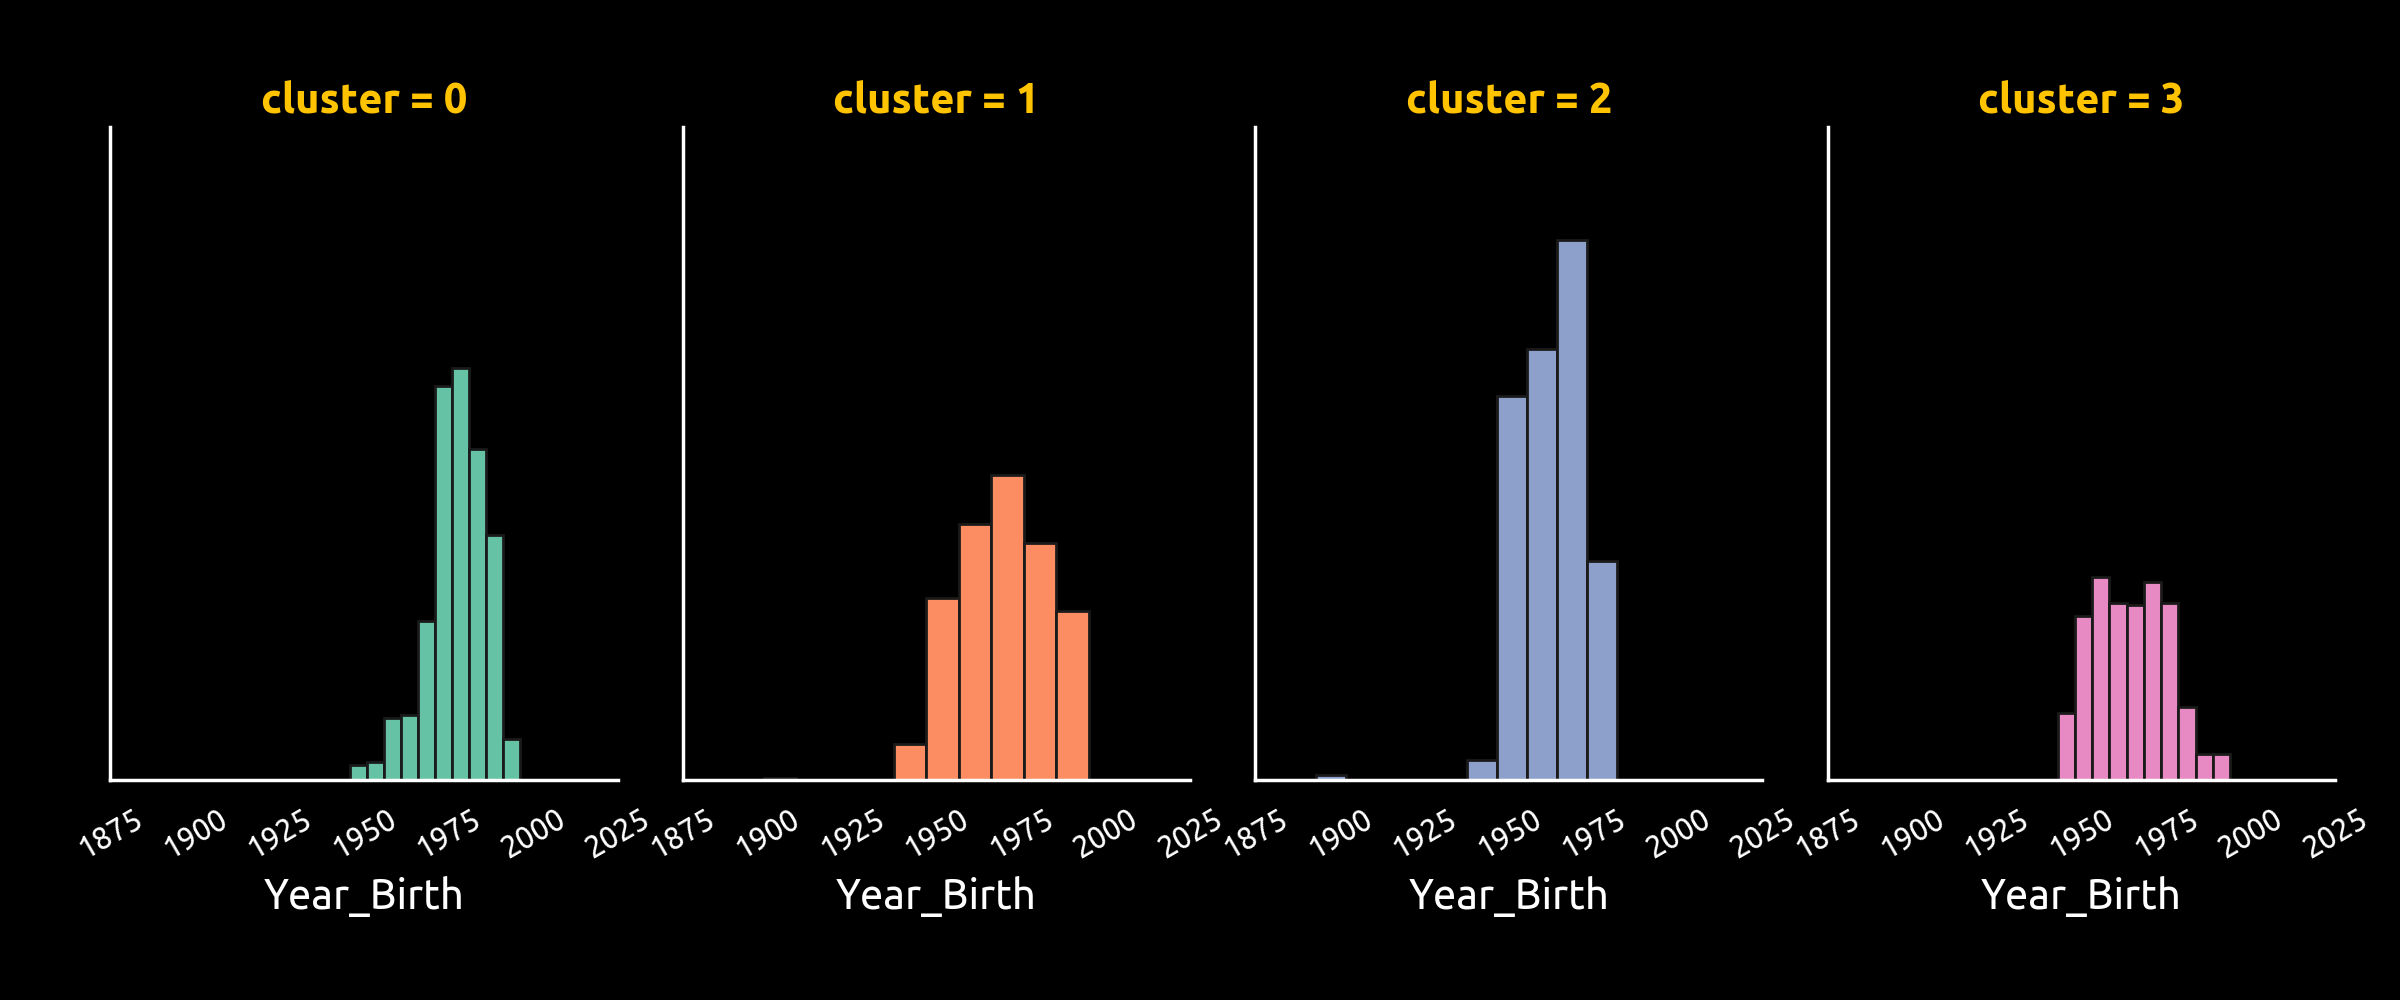

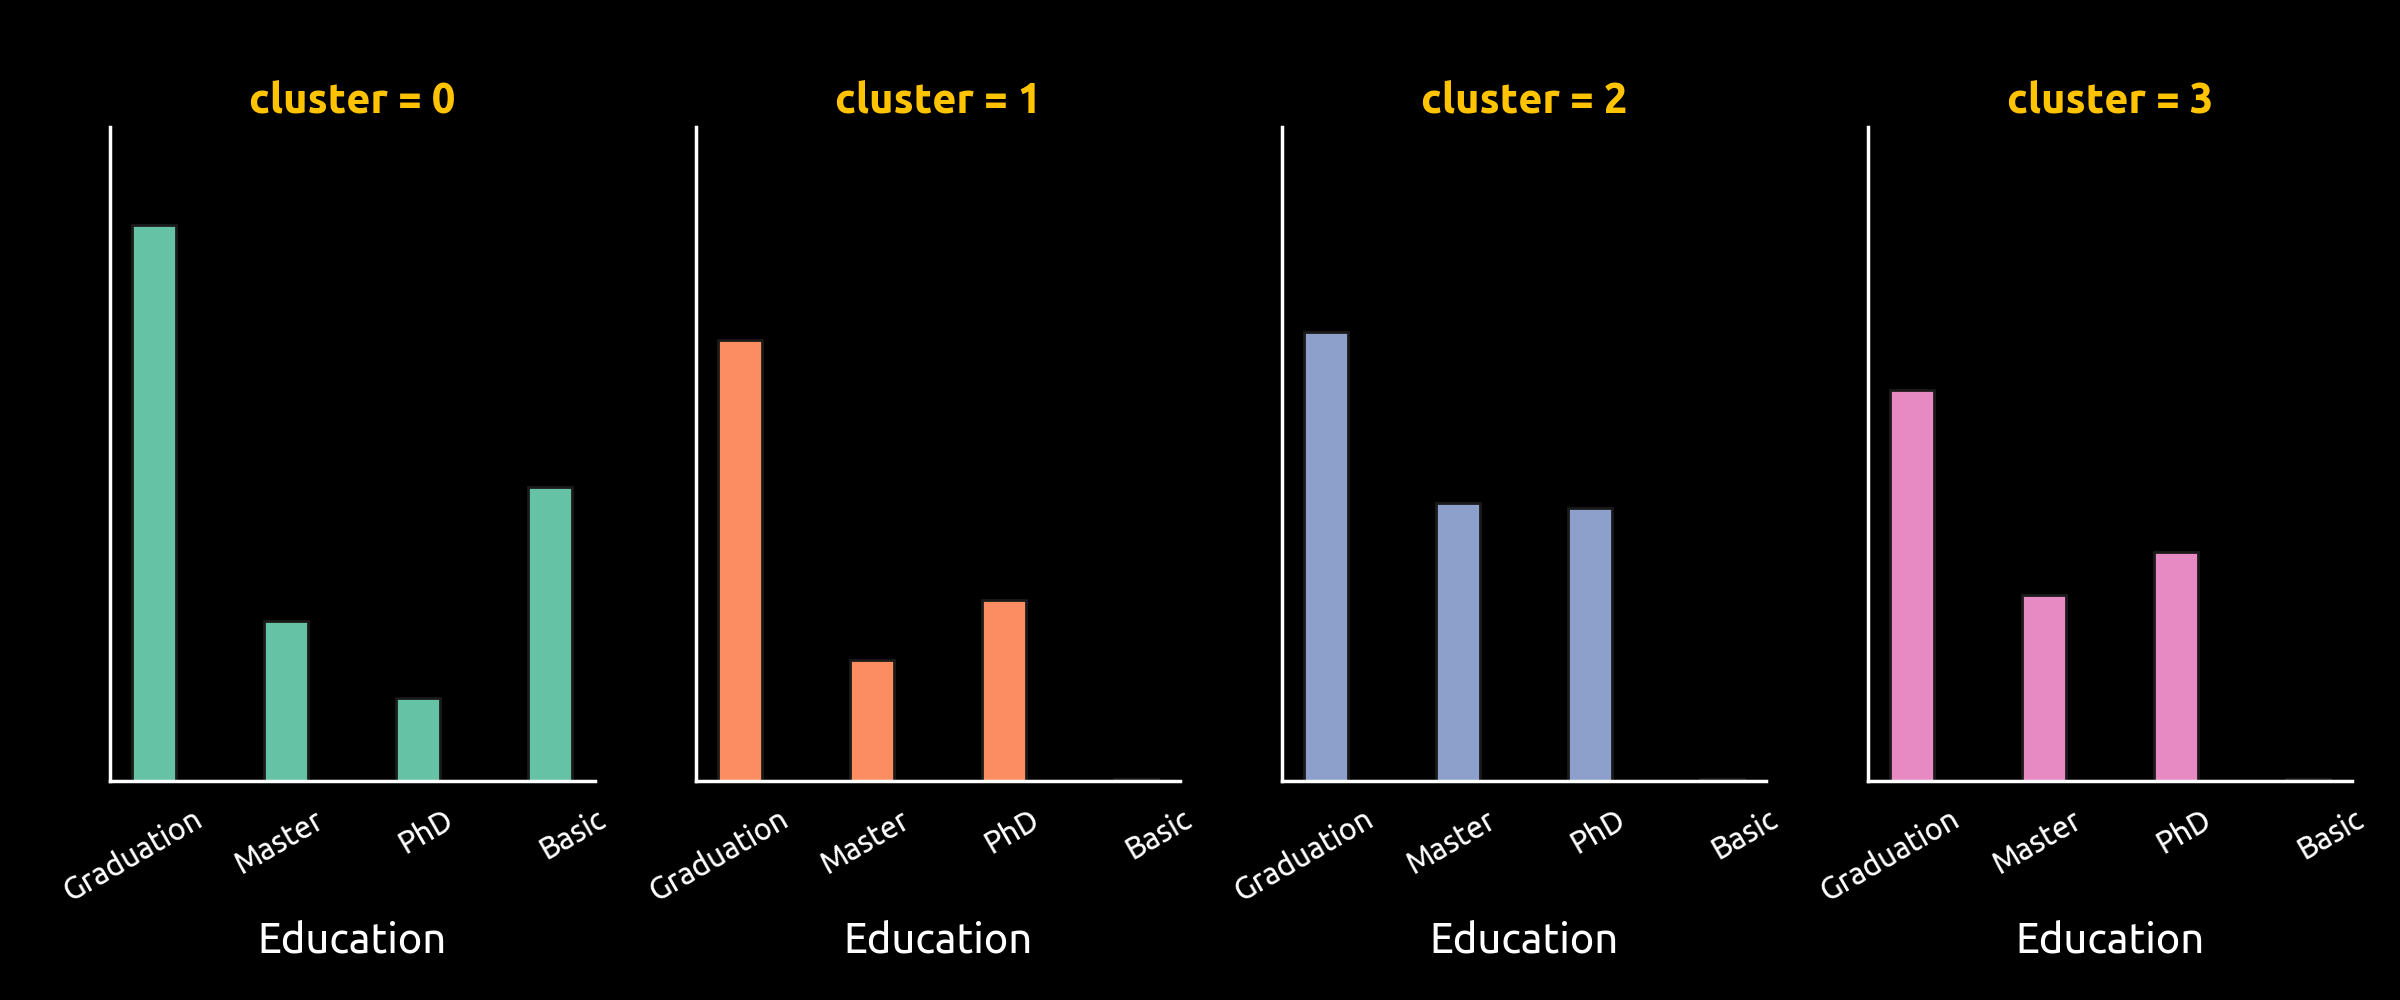

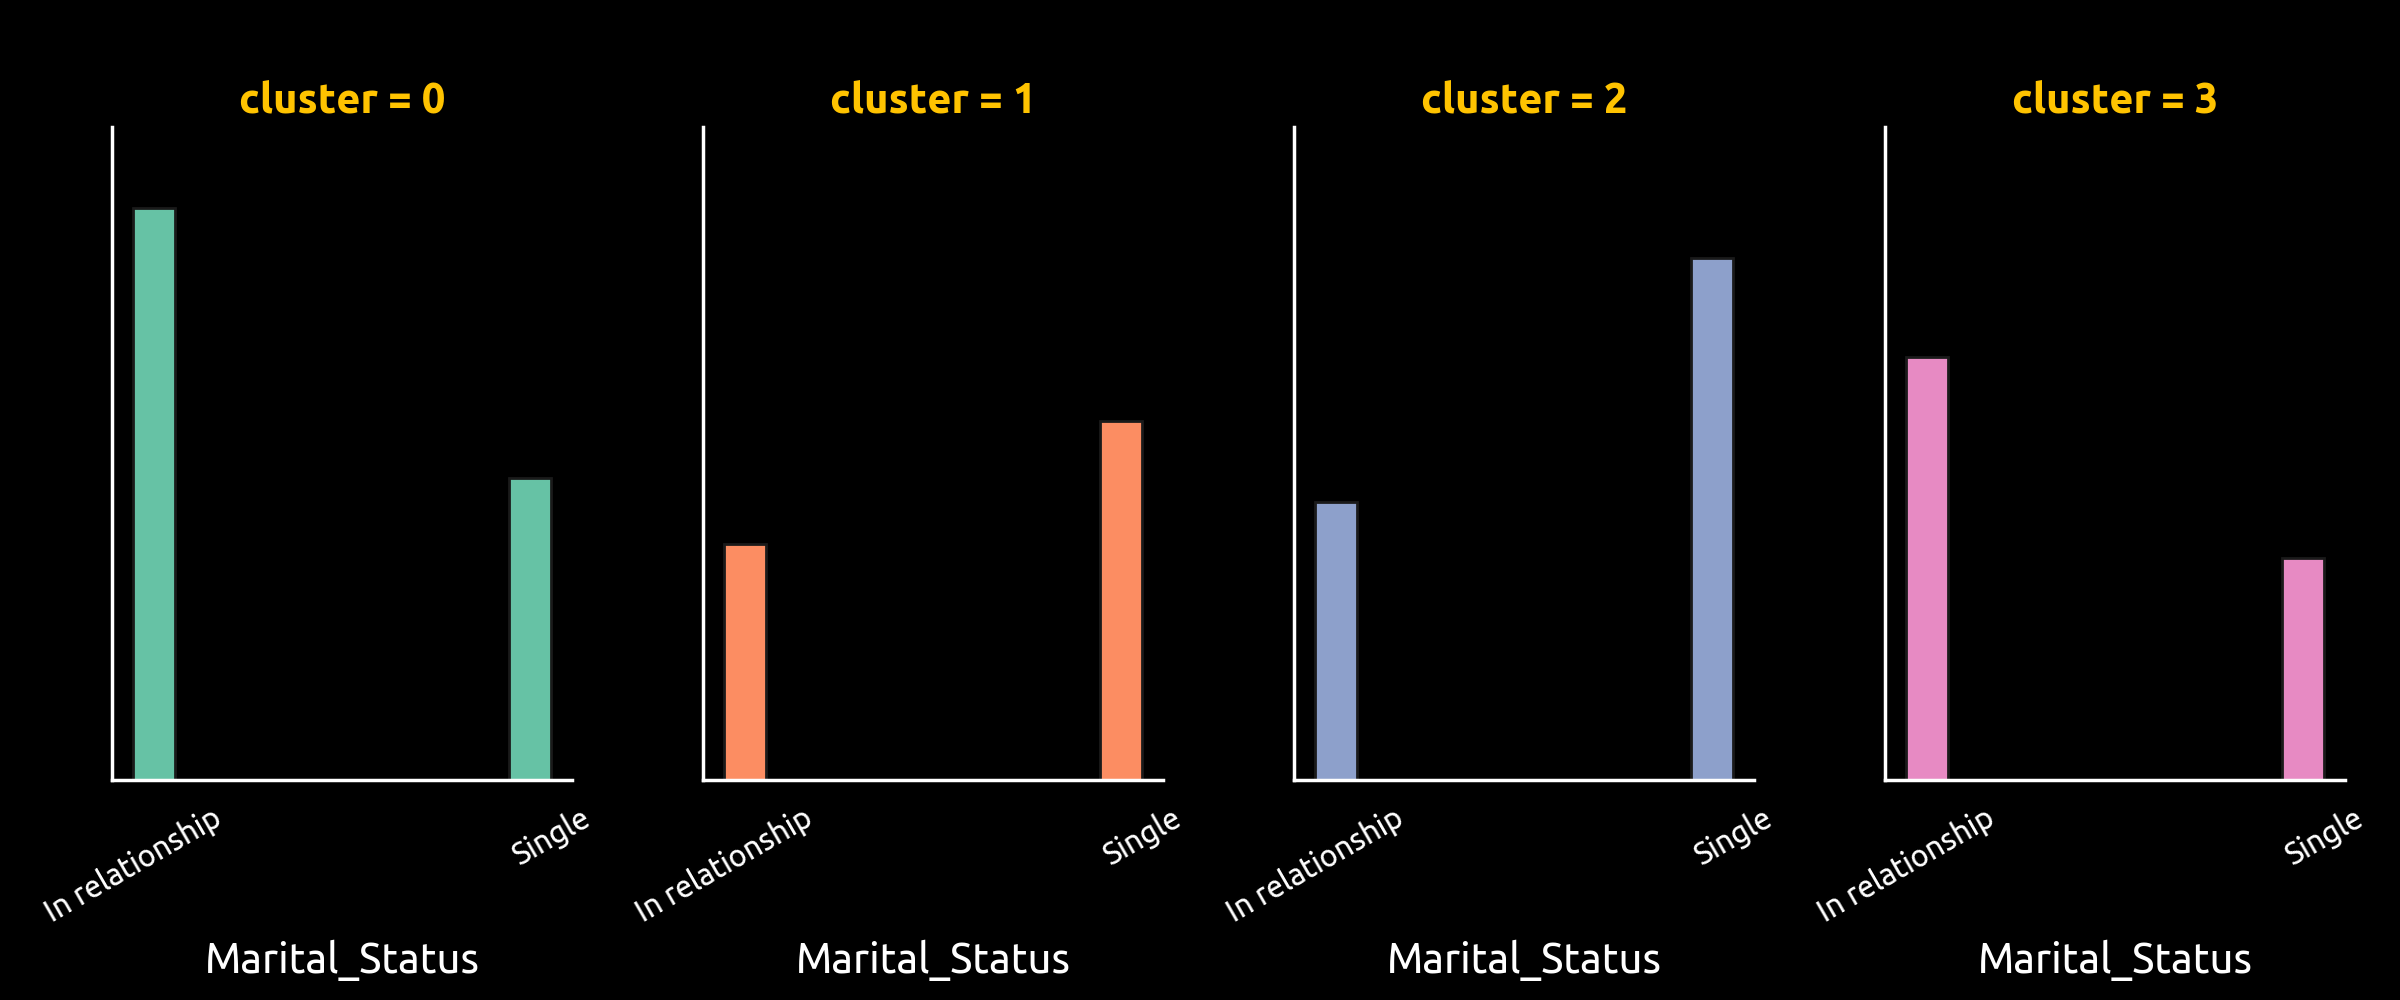

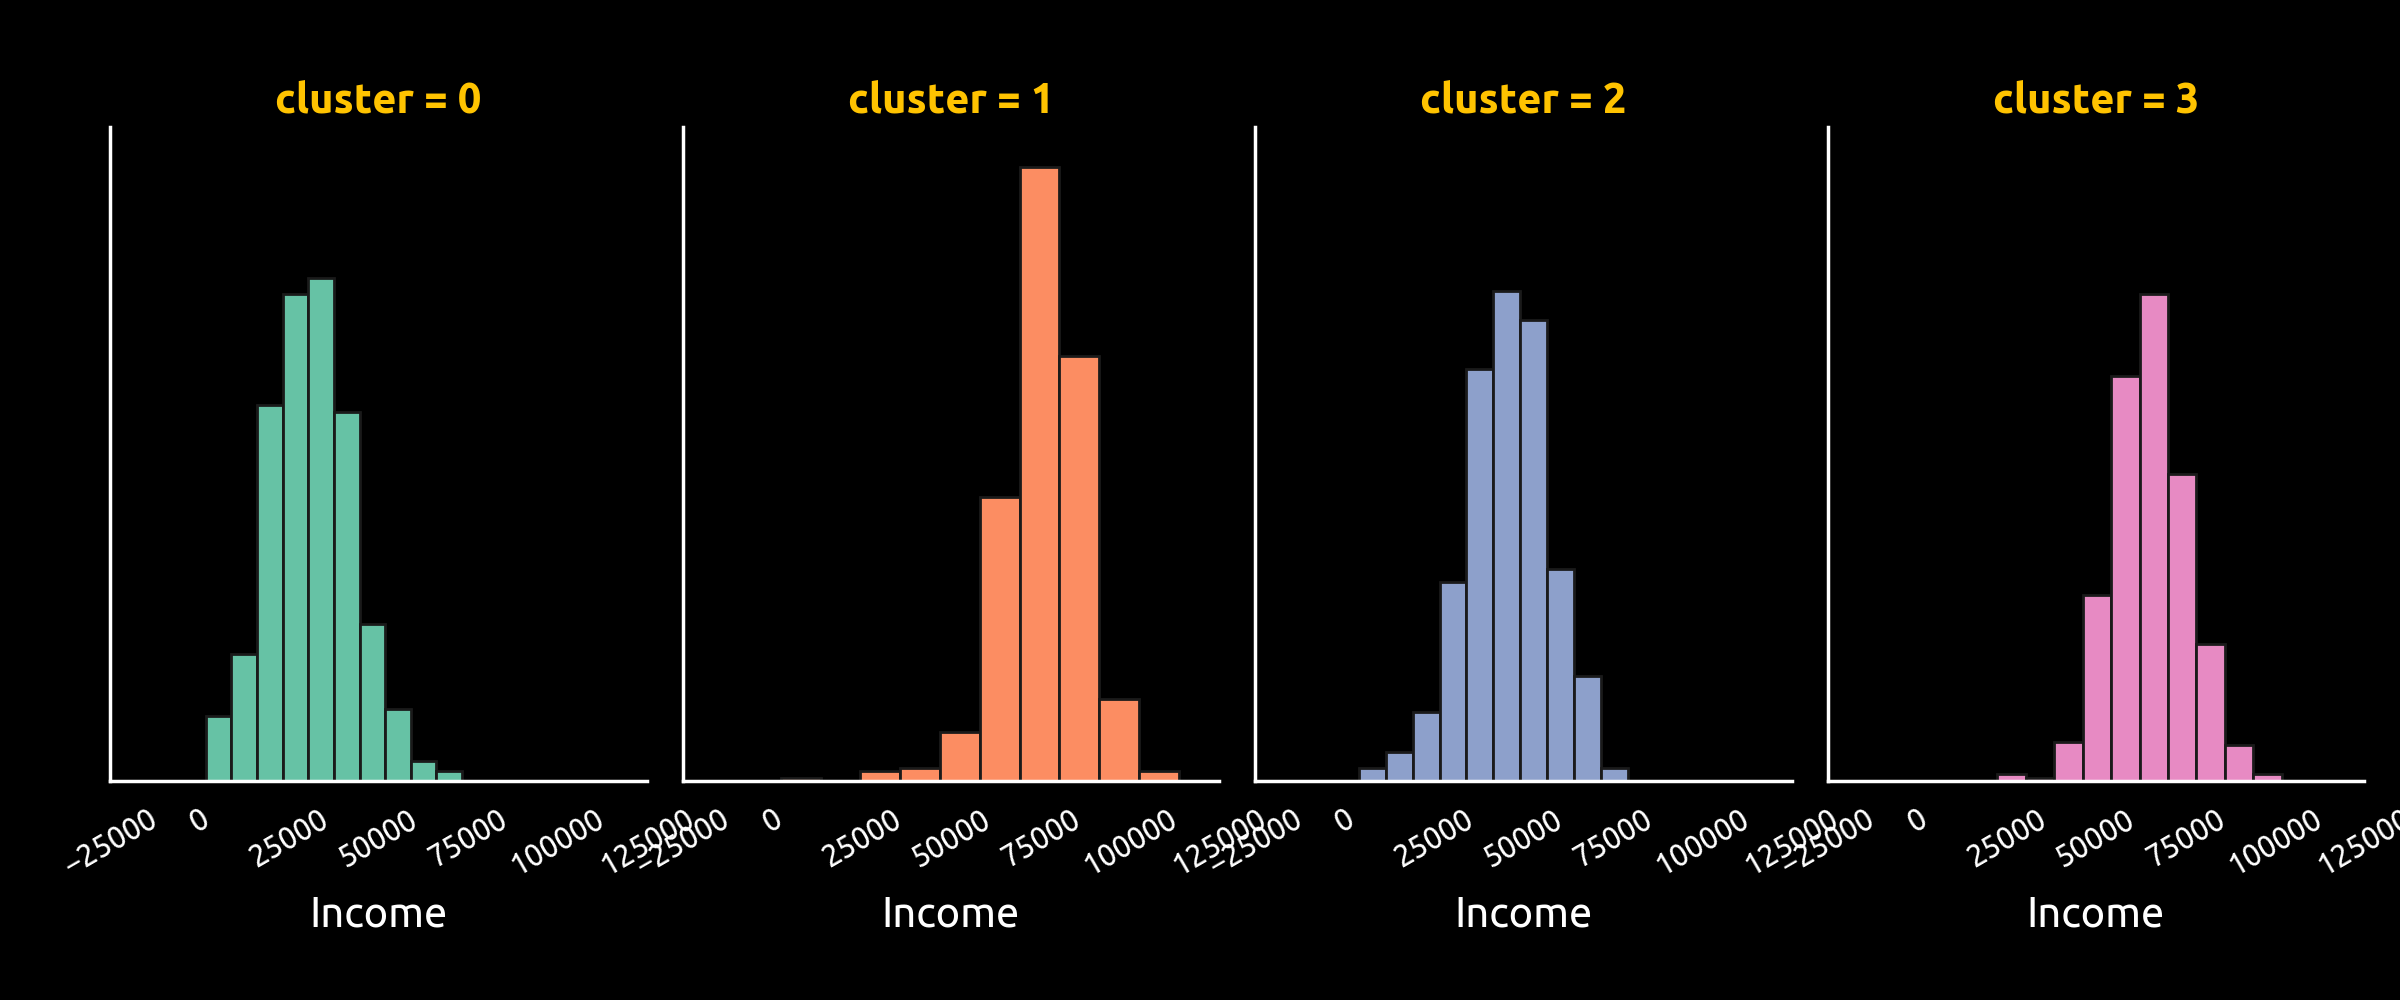

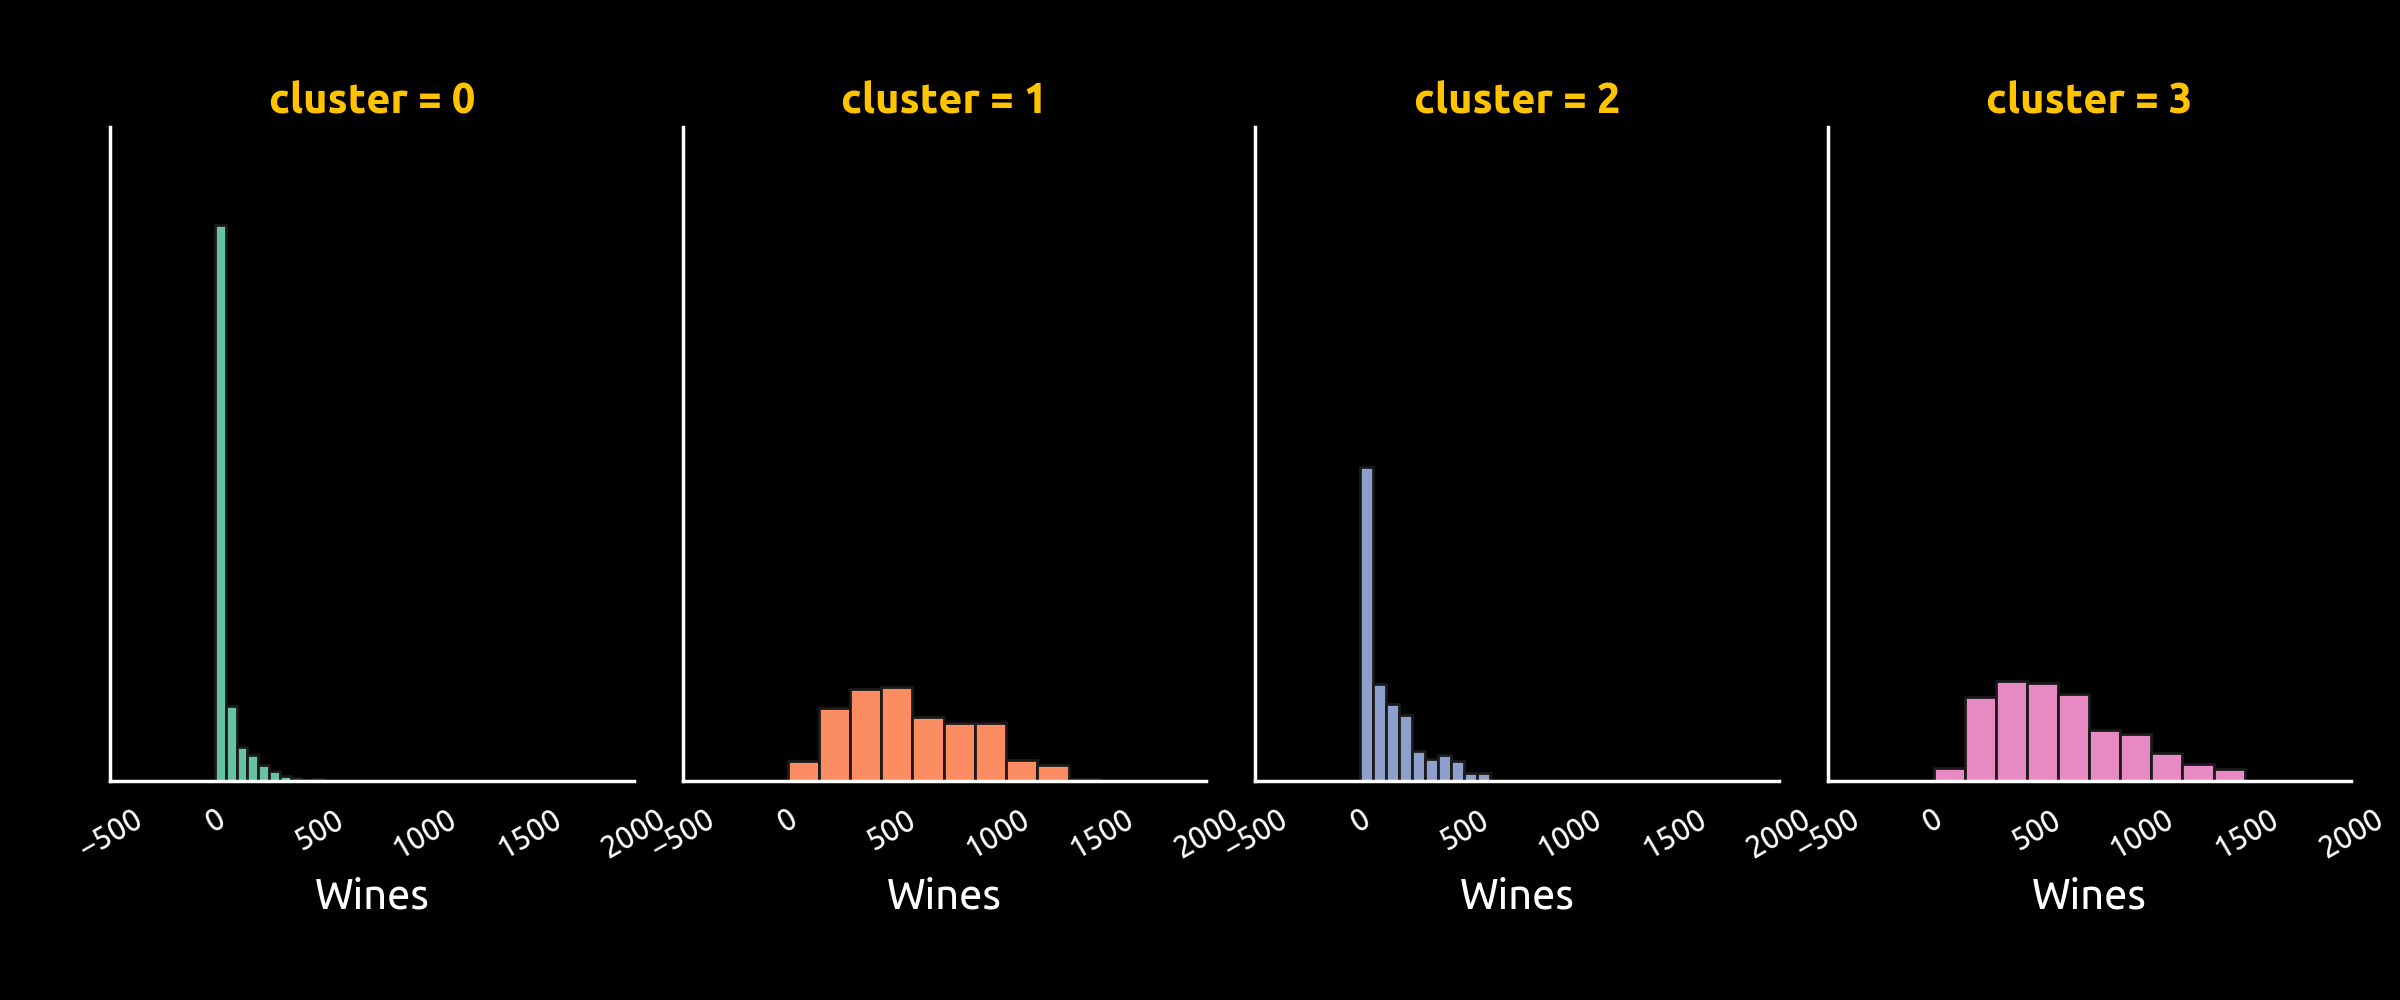

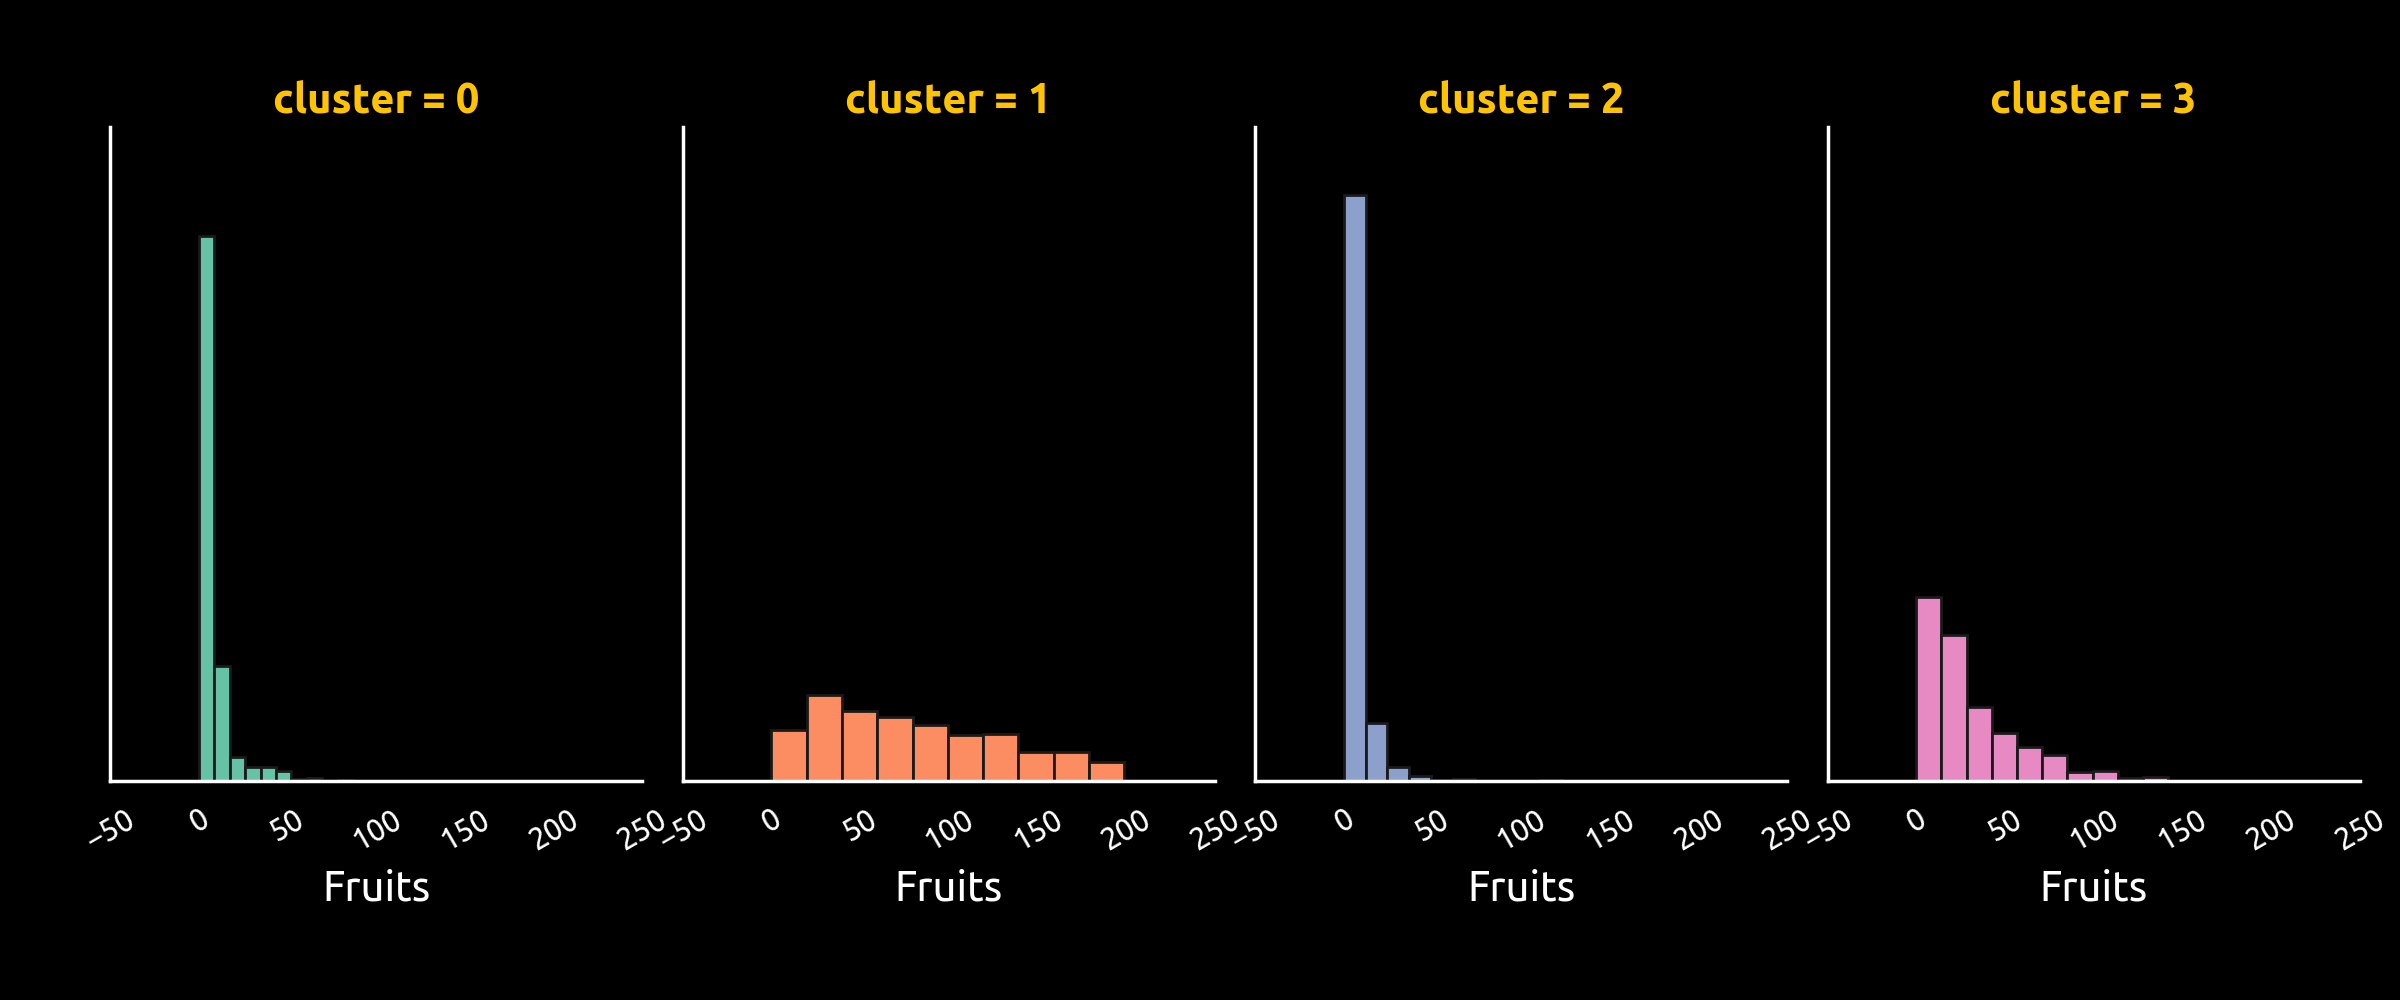

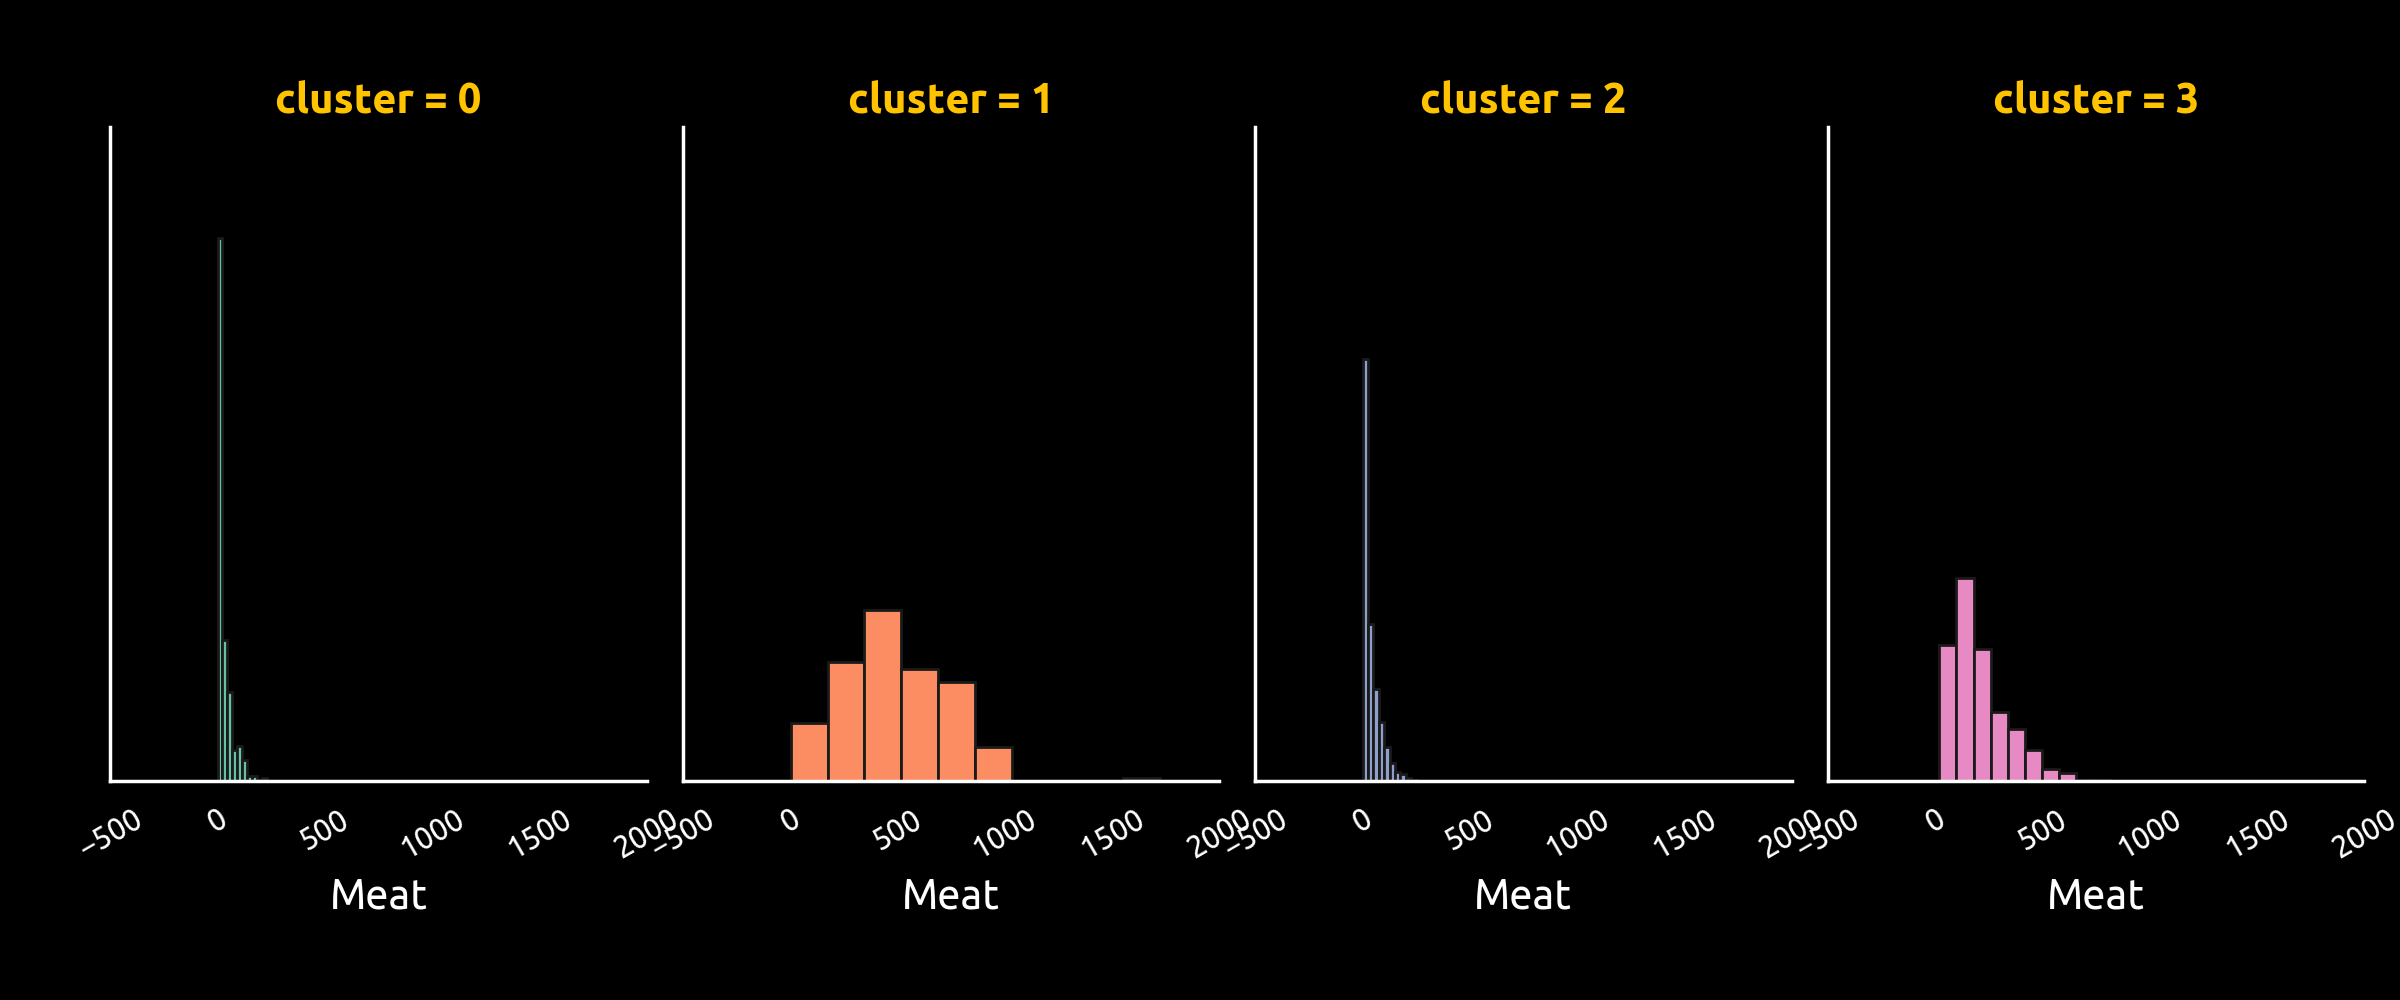

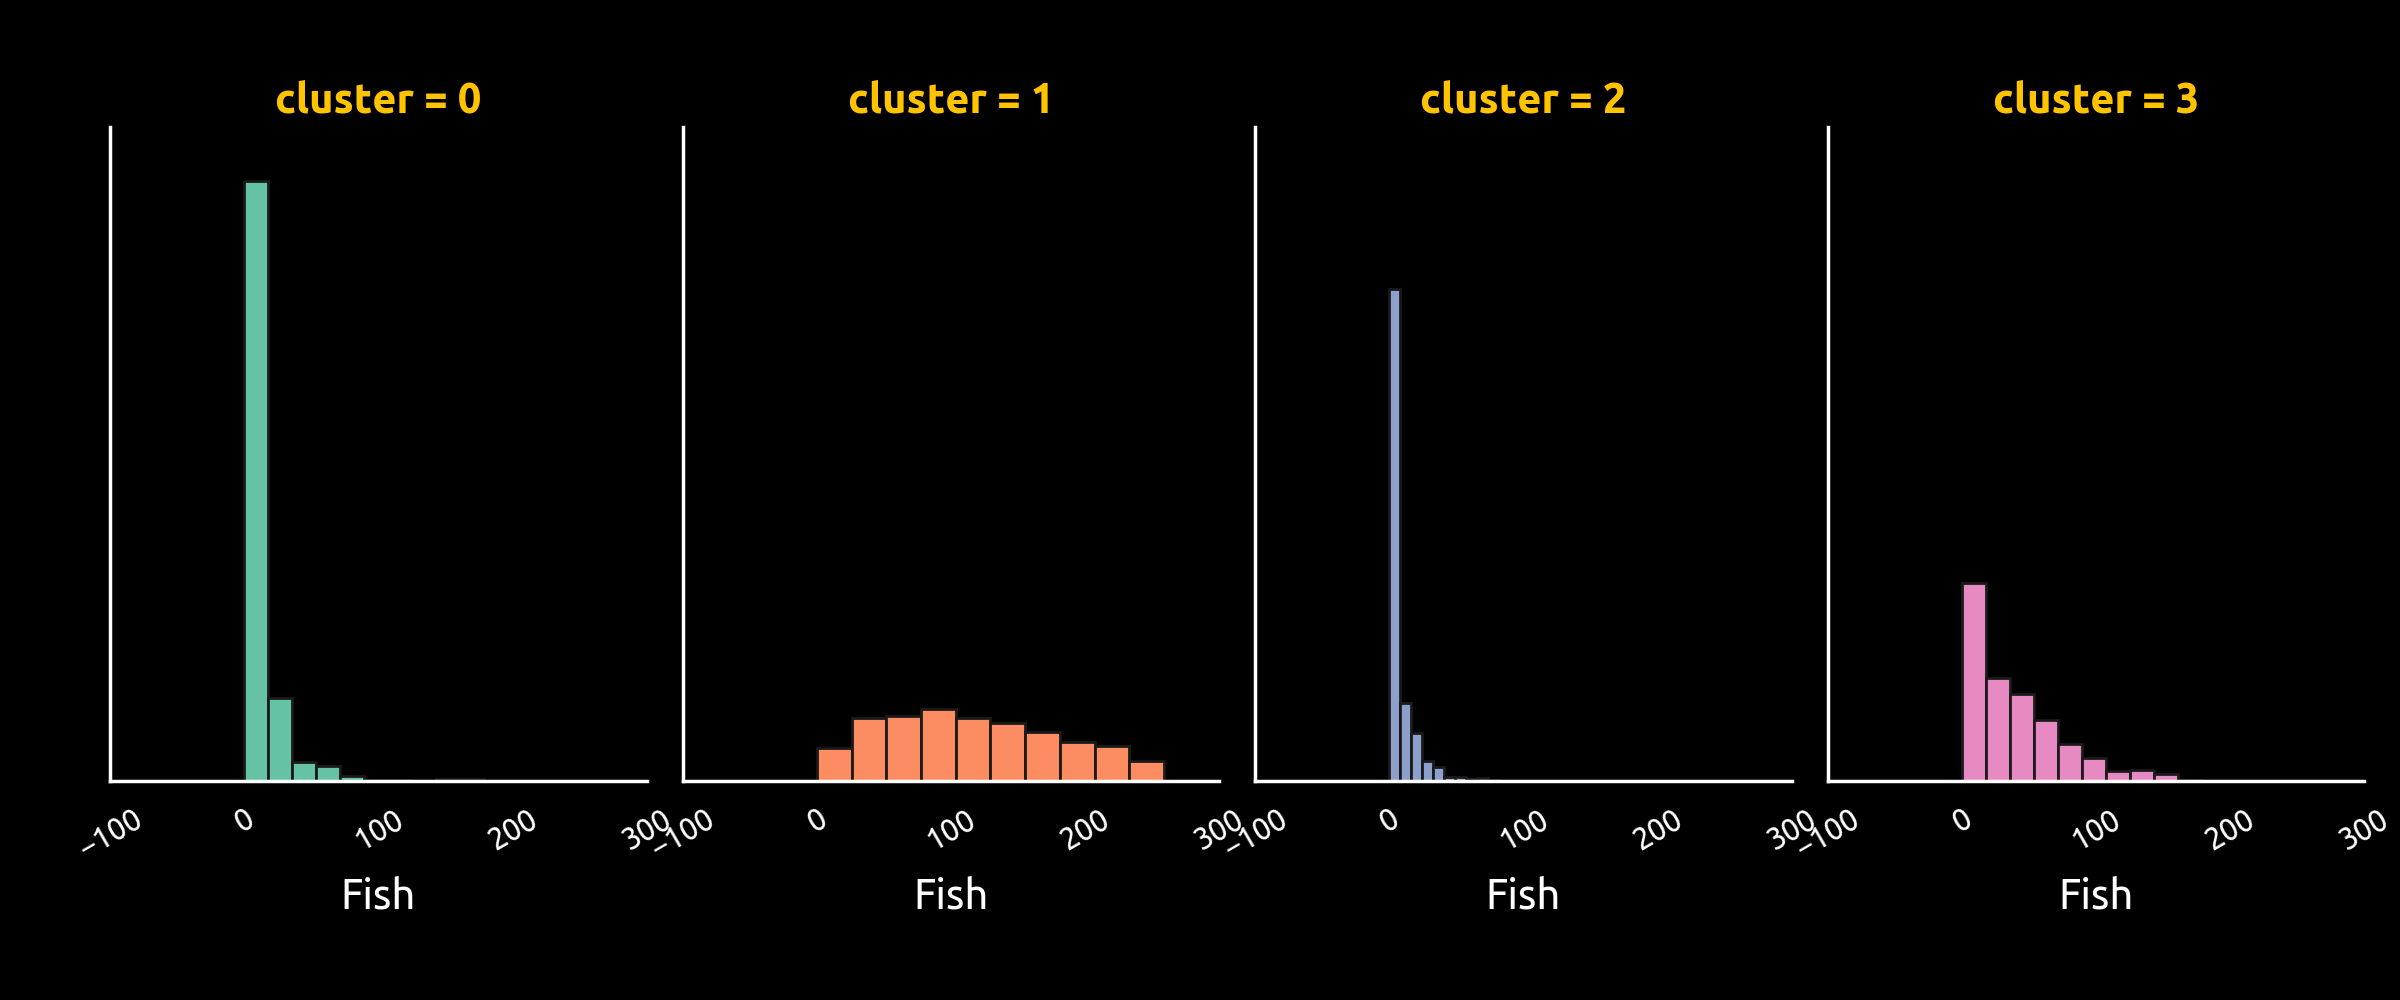

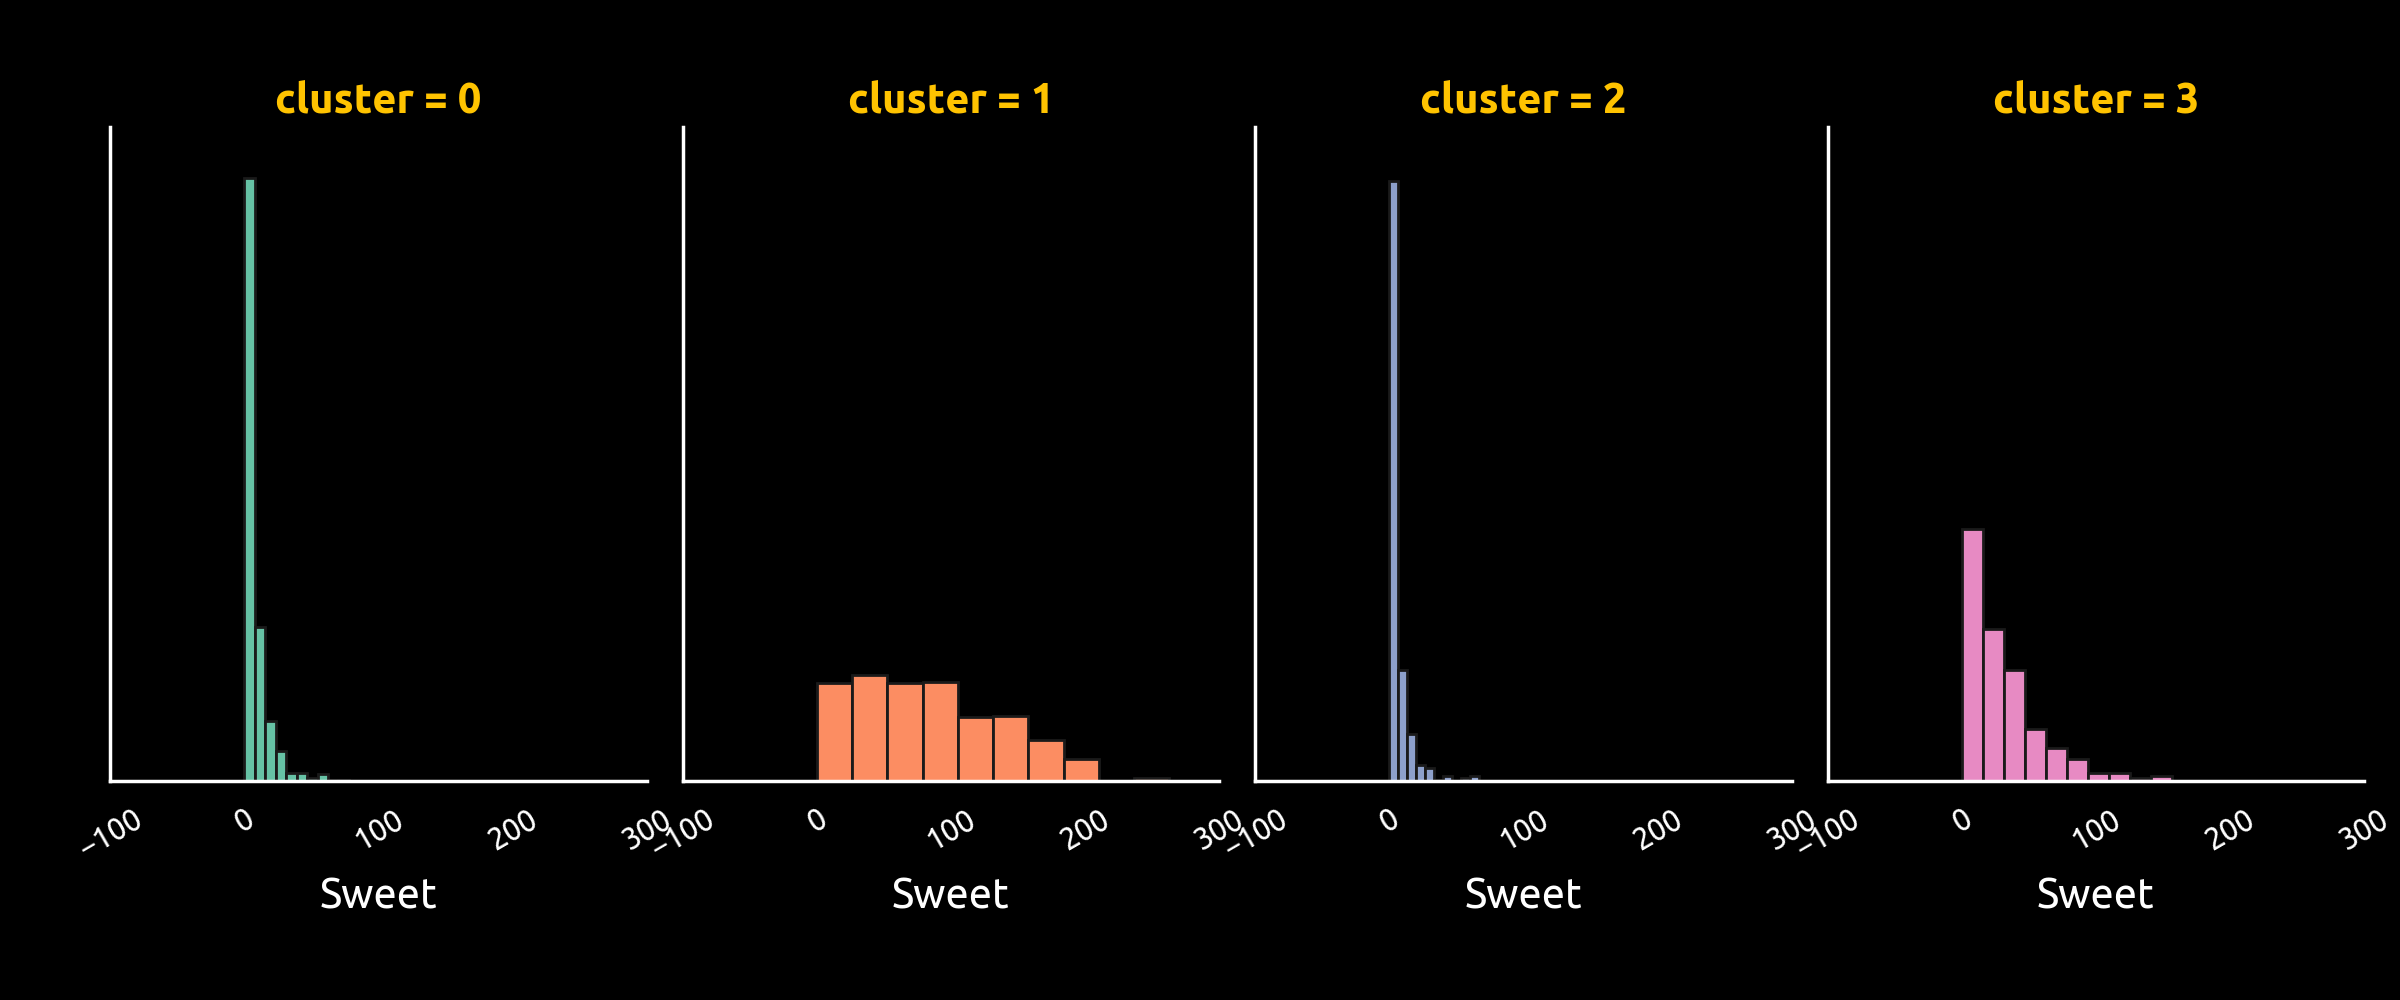

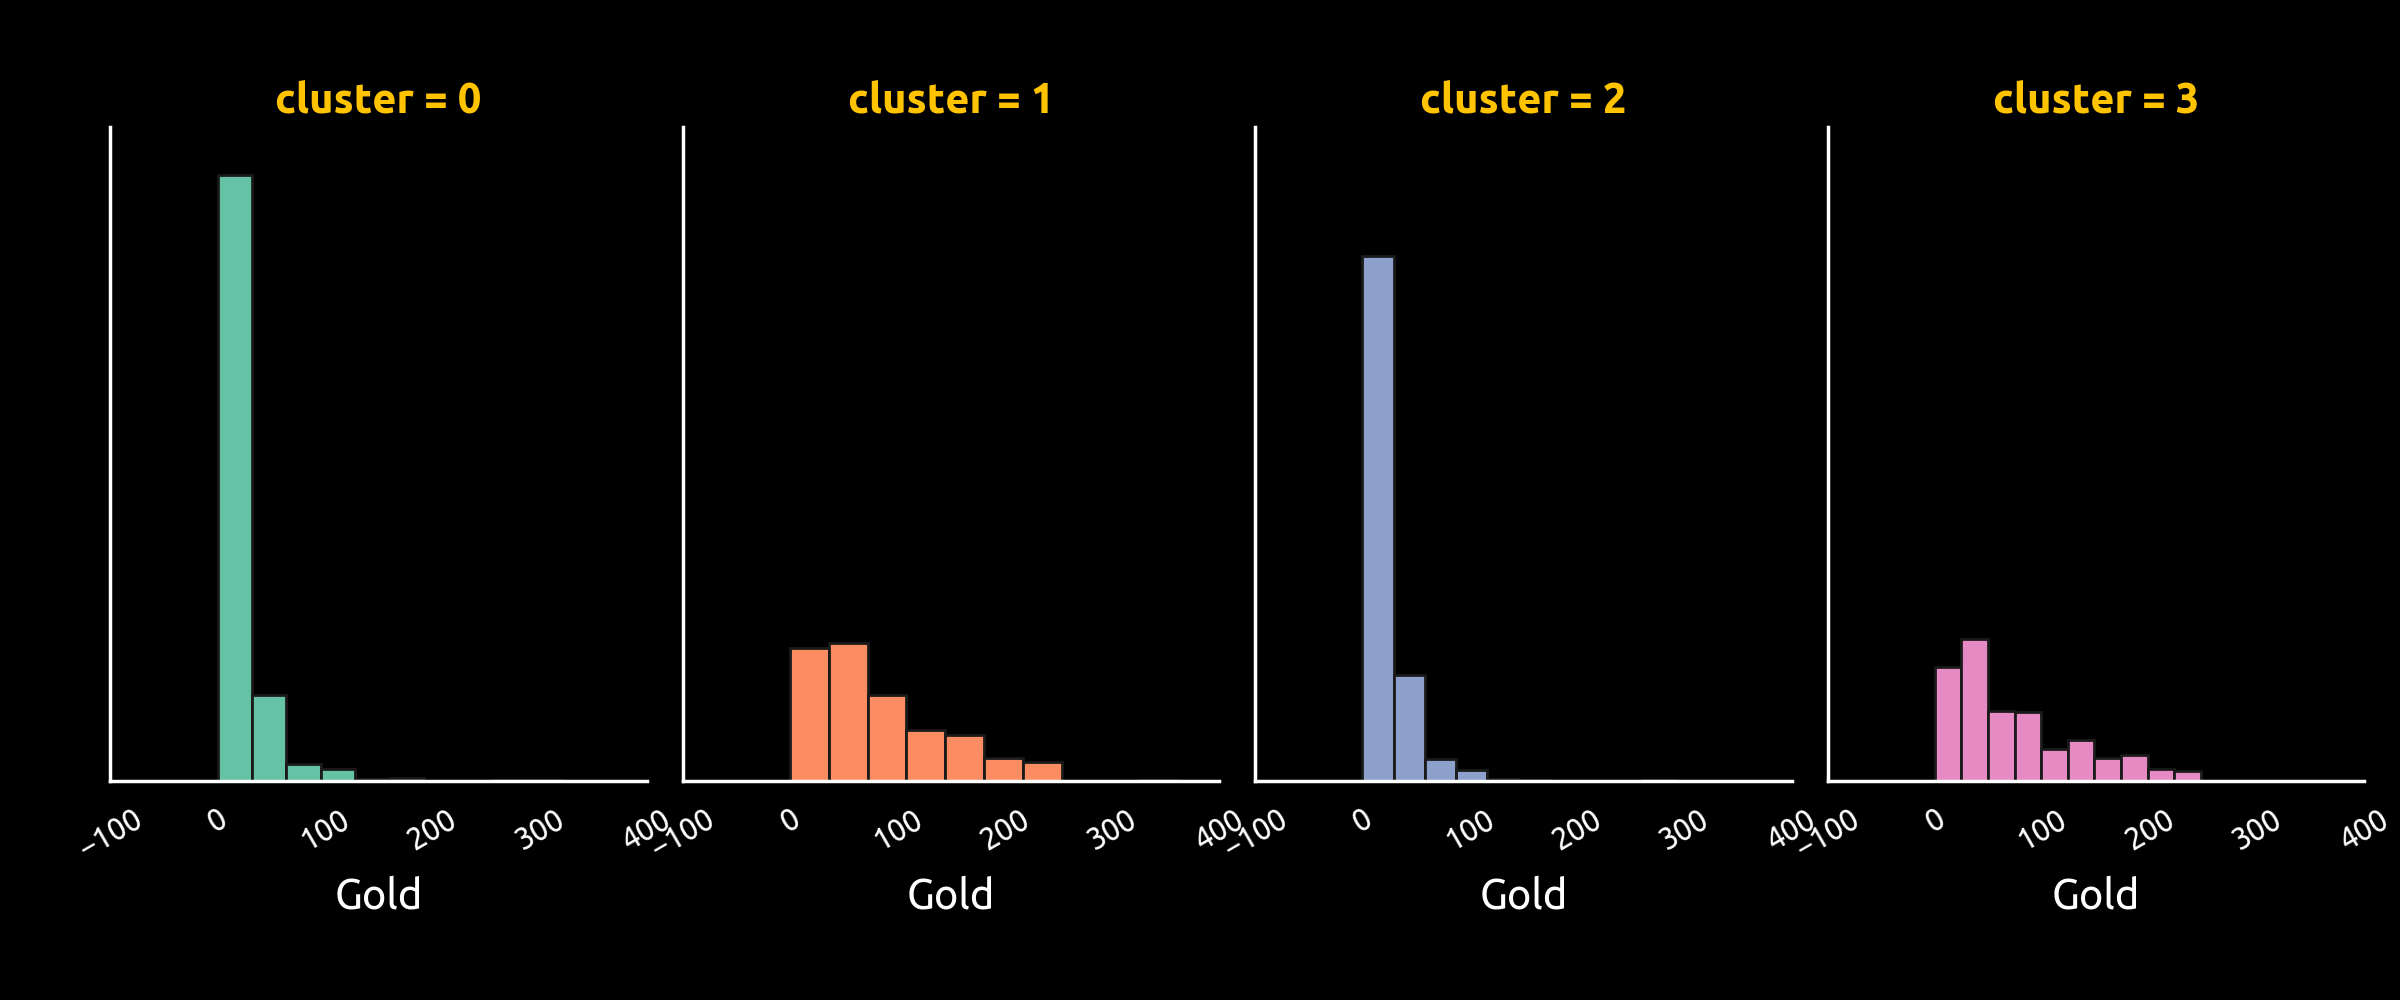

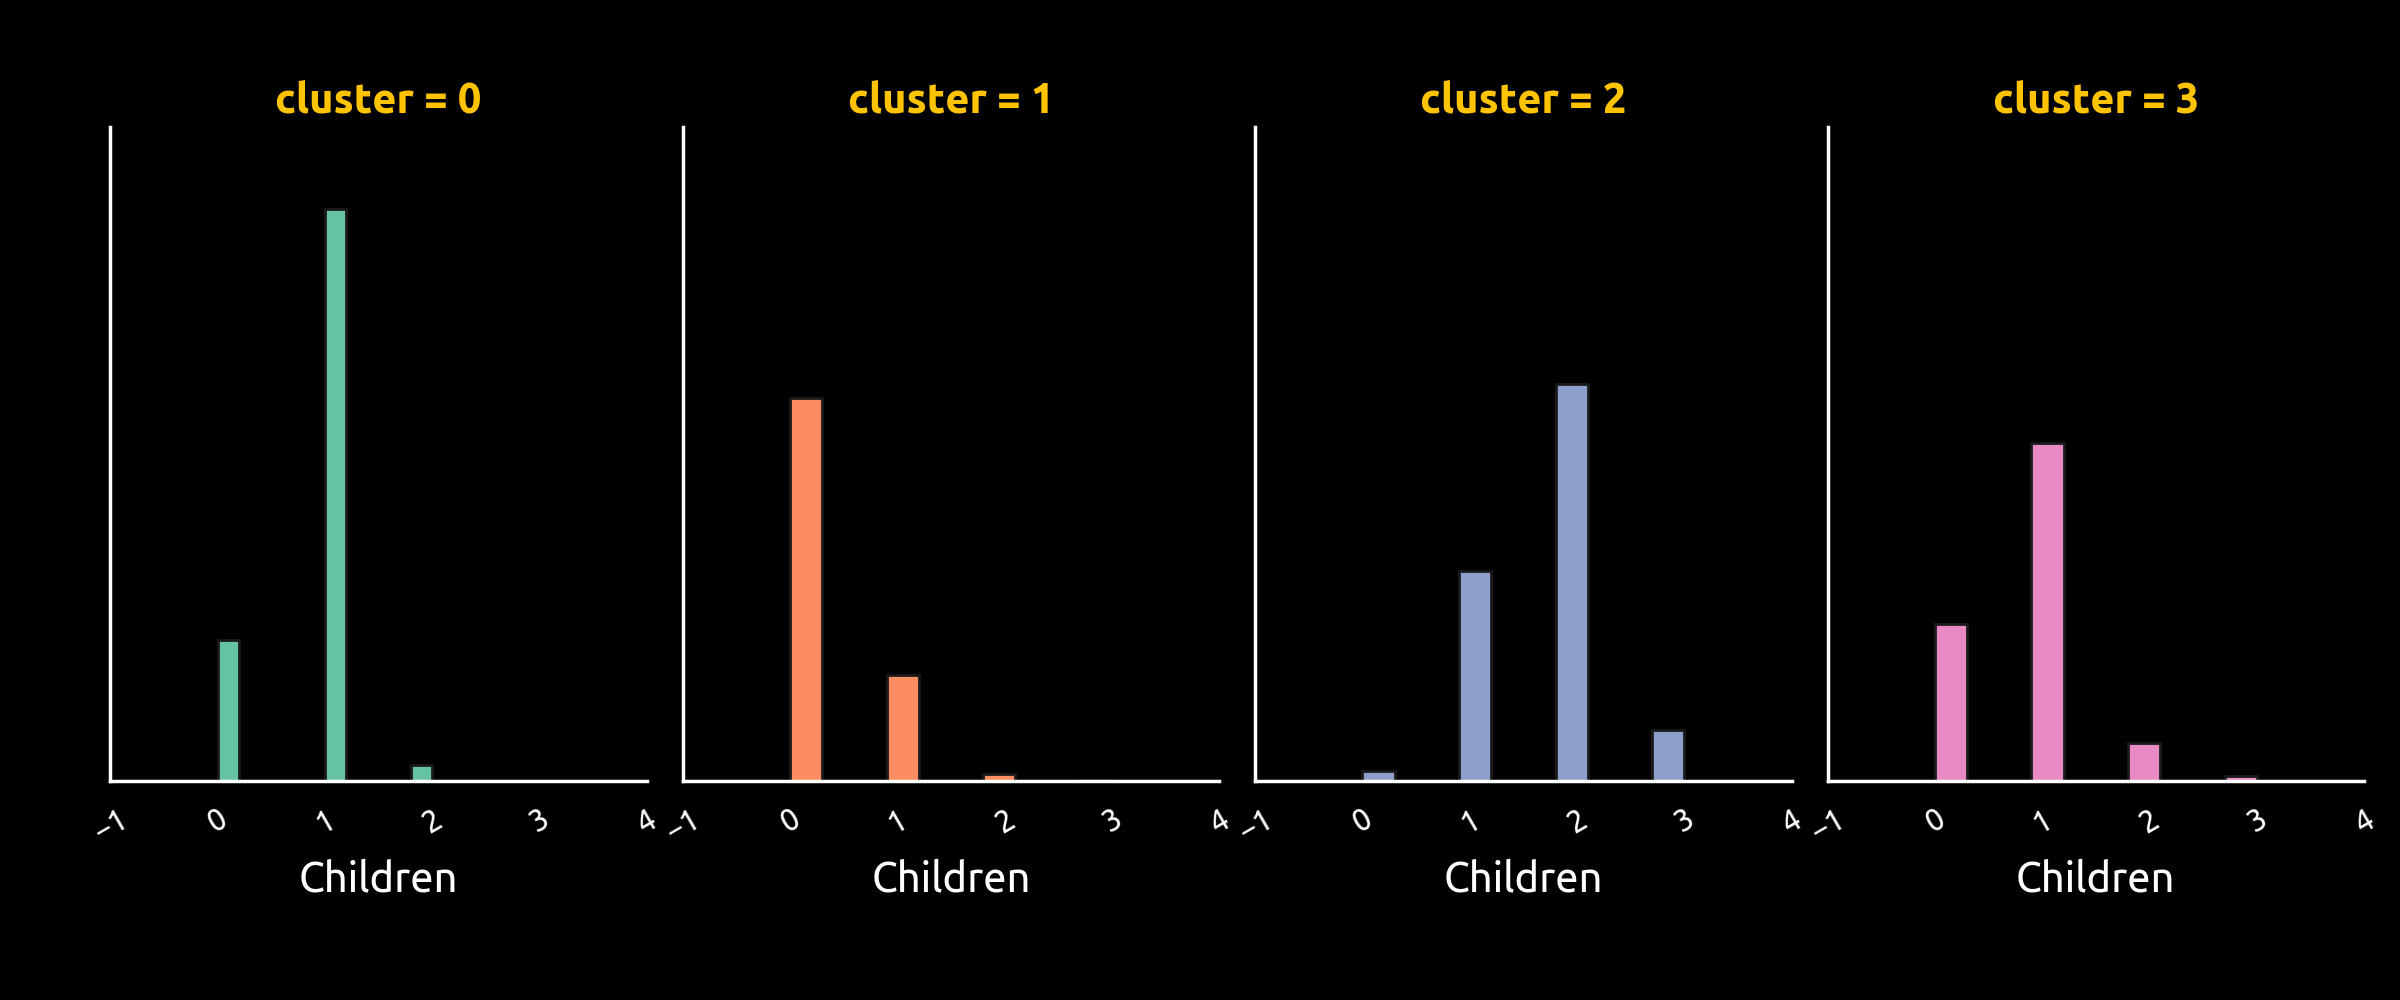

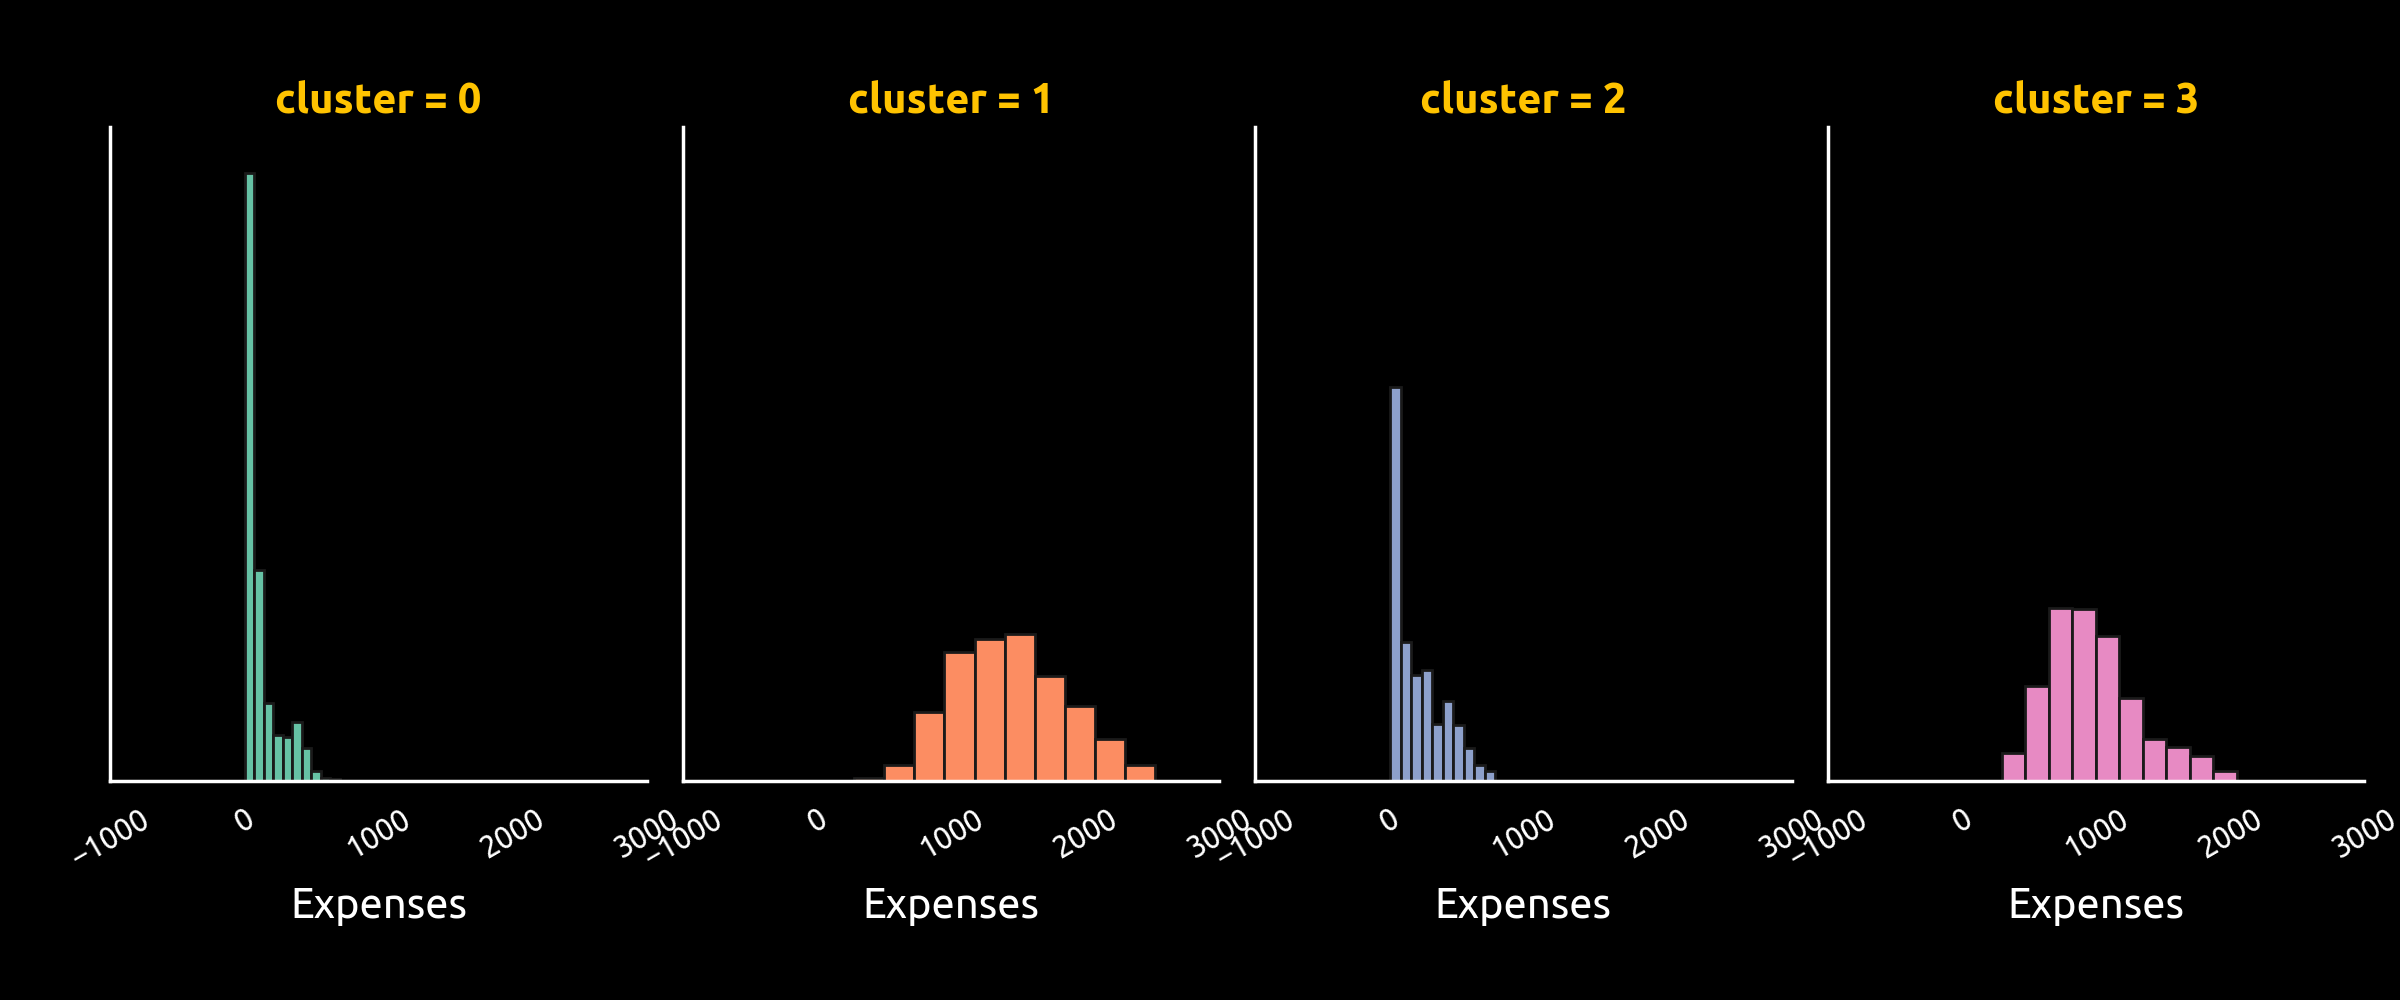

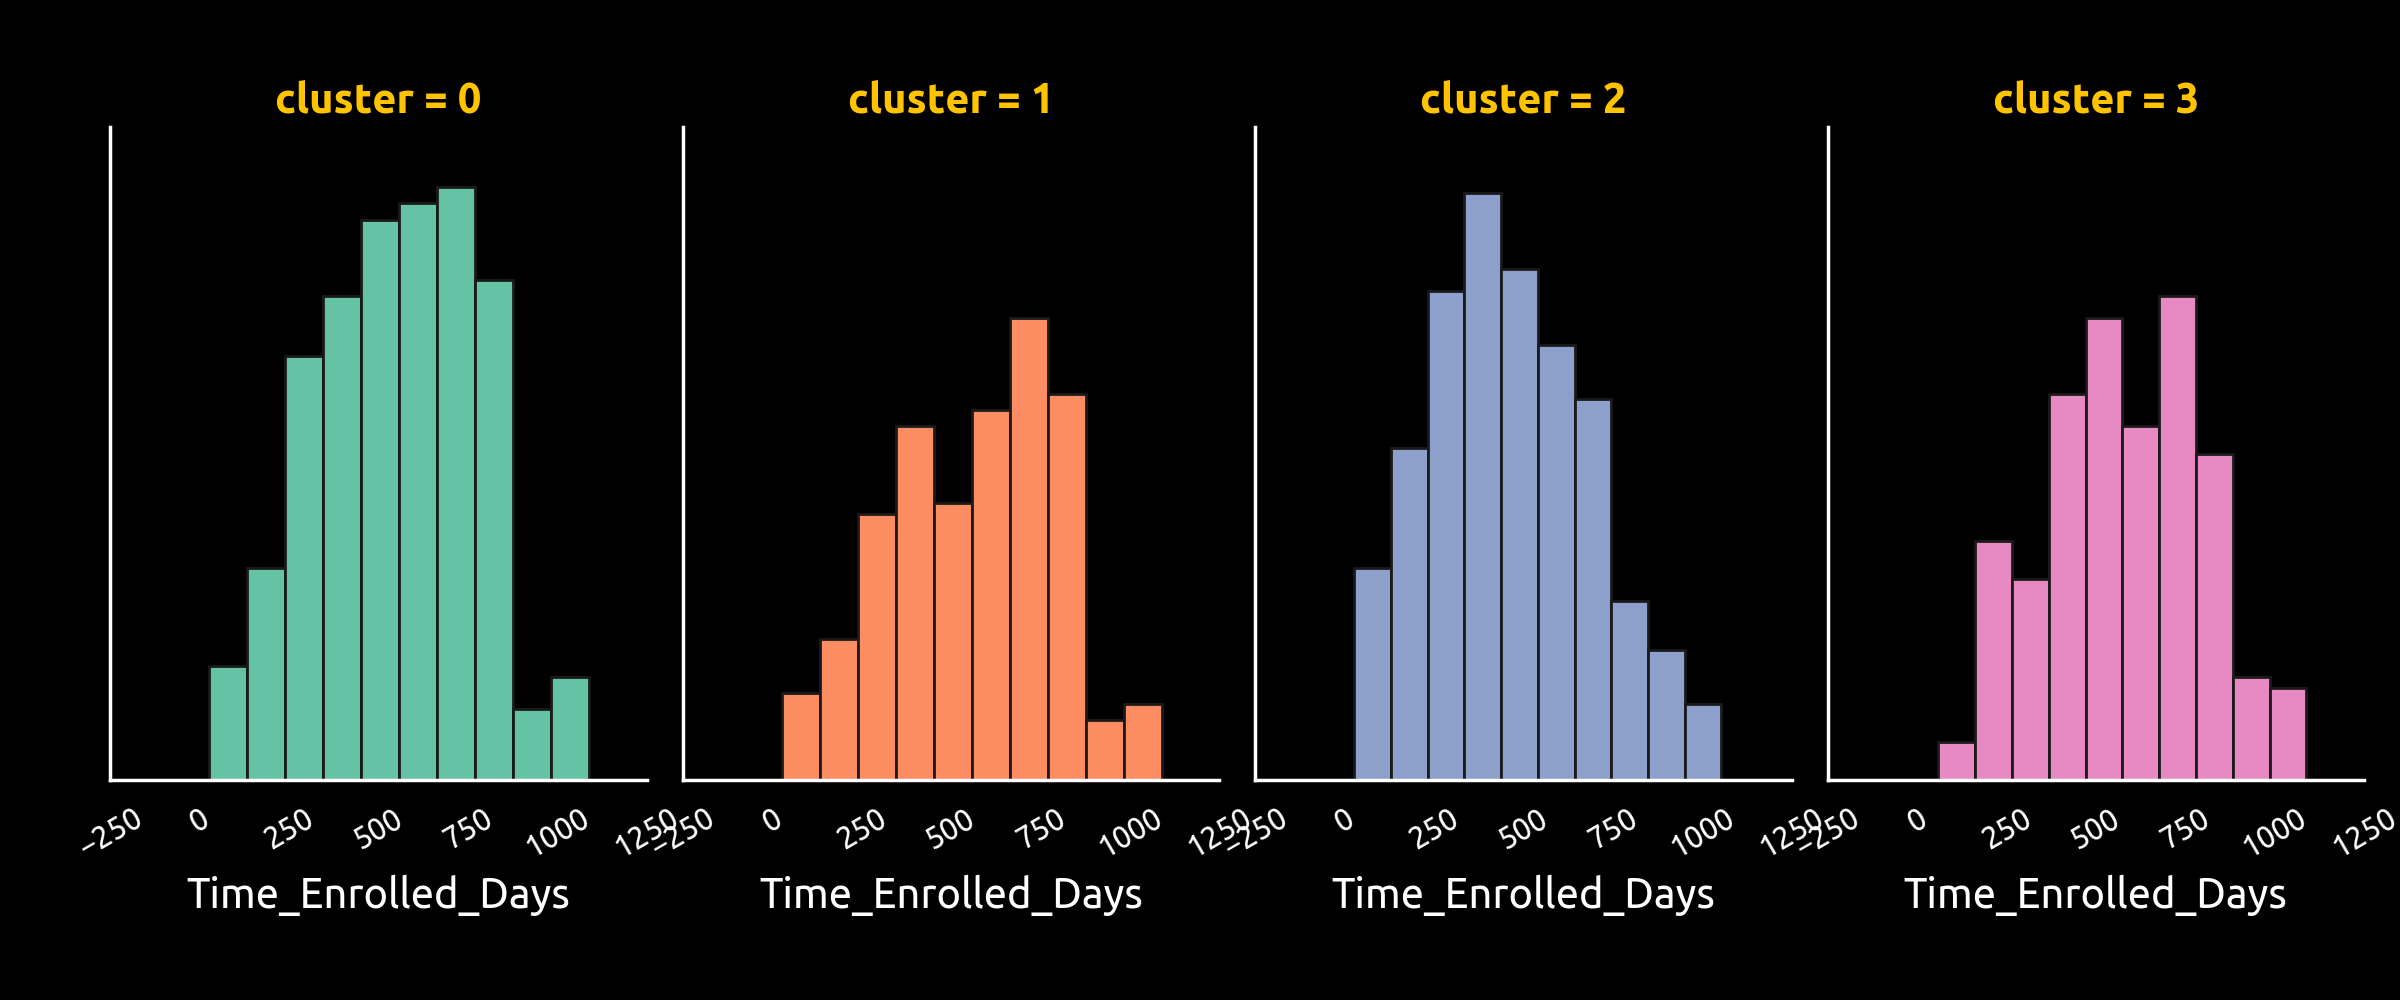

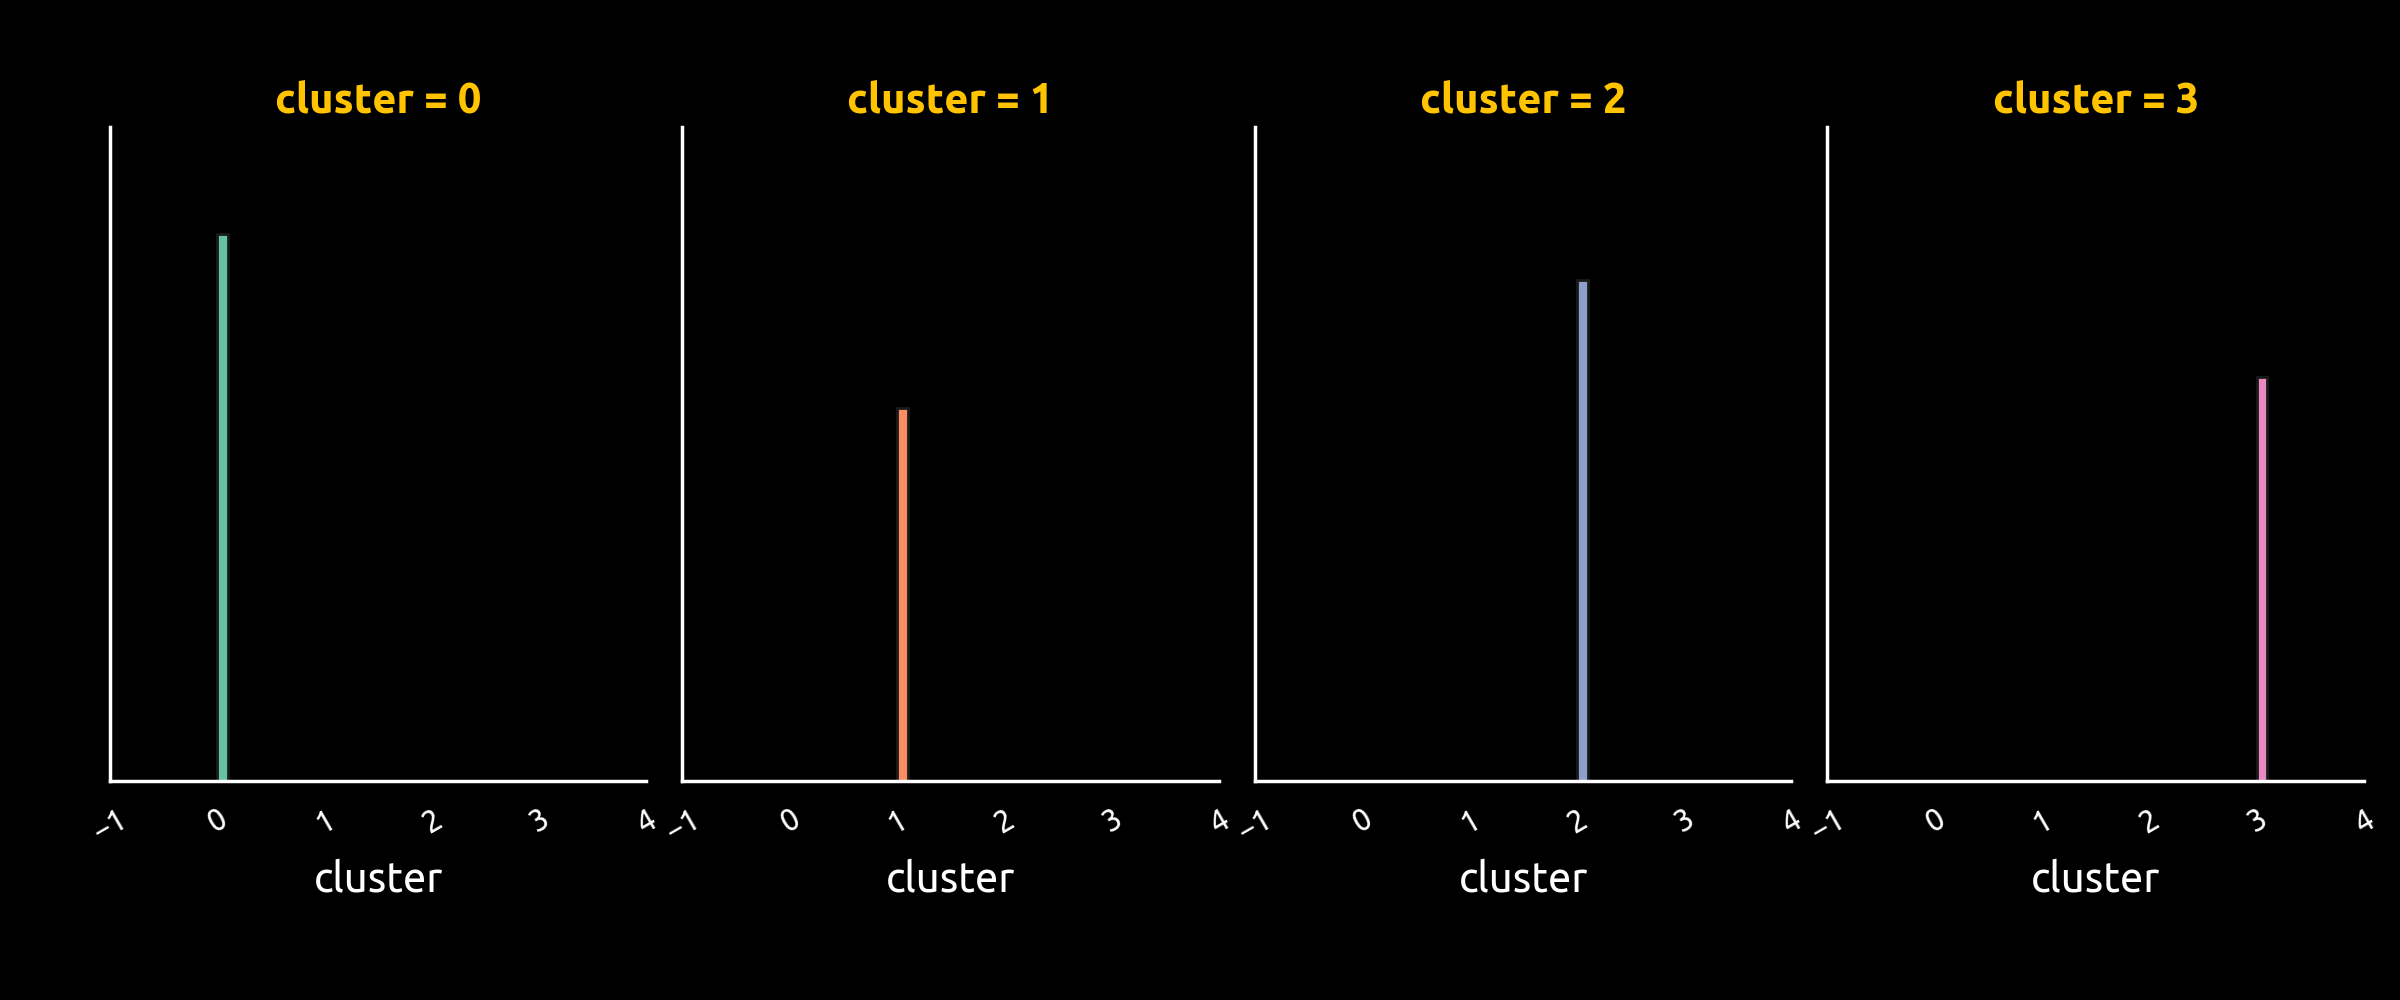

In [ ]:
# Clusters interpretation
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'font.family': 'Ubuntu'})

for i in df_clusters:
    g = sns.FacetGrid(df_clusters, col = "cluster", hue = "cluster", palette = "Set2")
    g.map(plt.hist, i, bins=10, ec="k") 
    g.set_xticklabels(rotation=30, color = 'white')
    g.set_yticklabels(color = 'white')
    g.set_xlabels(size=15, color = 'white')
    g.set_titles(size=15, color = '#FFC300', fontweight="bold")
    g.fig.set_figheight(5)

Cluster 0: People with high incomes and high spending habits that tend to have one child. We will call this group good customers.

Cluster 1: People with the highest incomes and the highest spending habits. We will call this group elite customers.

Cluster 2: People with lower incomes and low spending habits that also have the lowest time enrolled as a member. We will call this group economical customers.

Cluster 3: People with lowest incomes and lowest spending habits. We will call this group cheap customers.

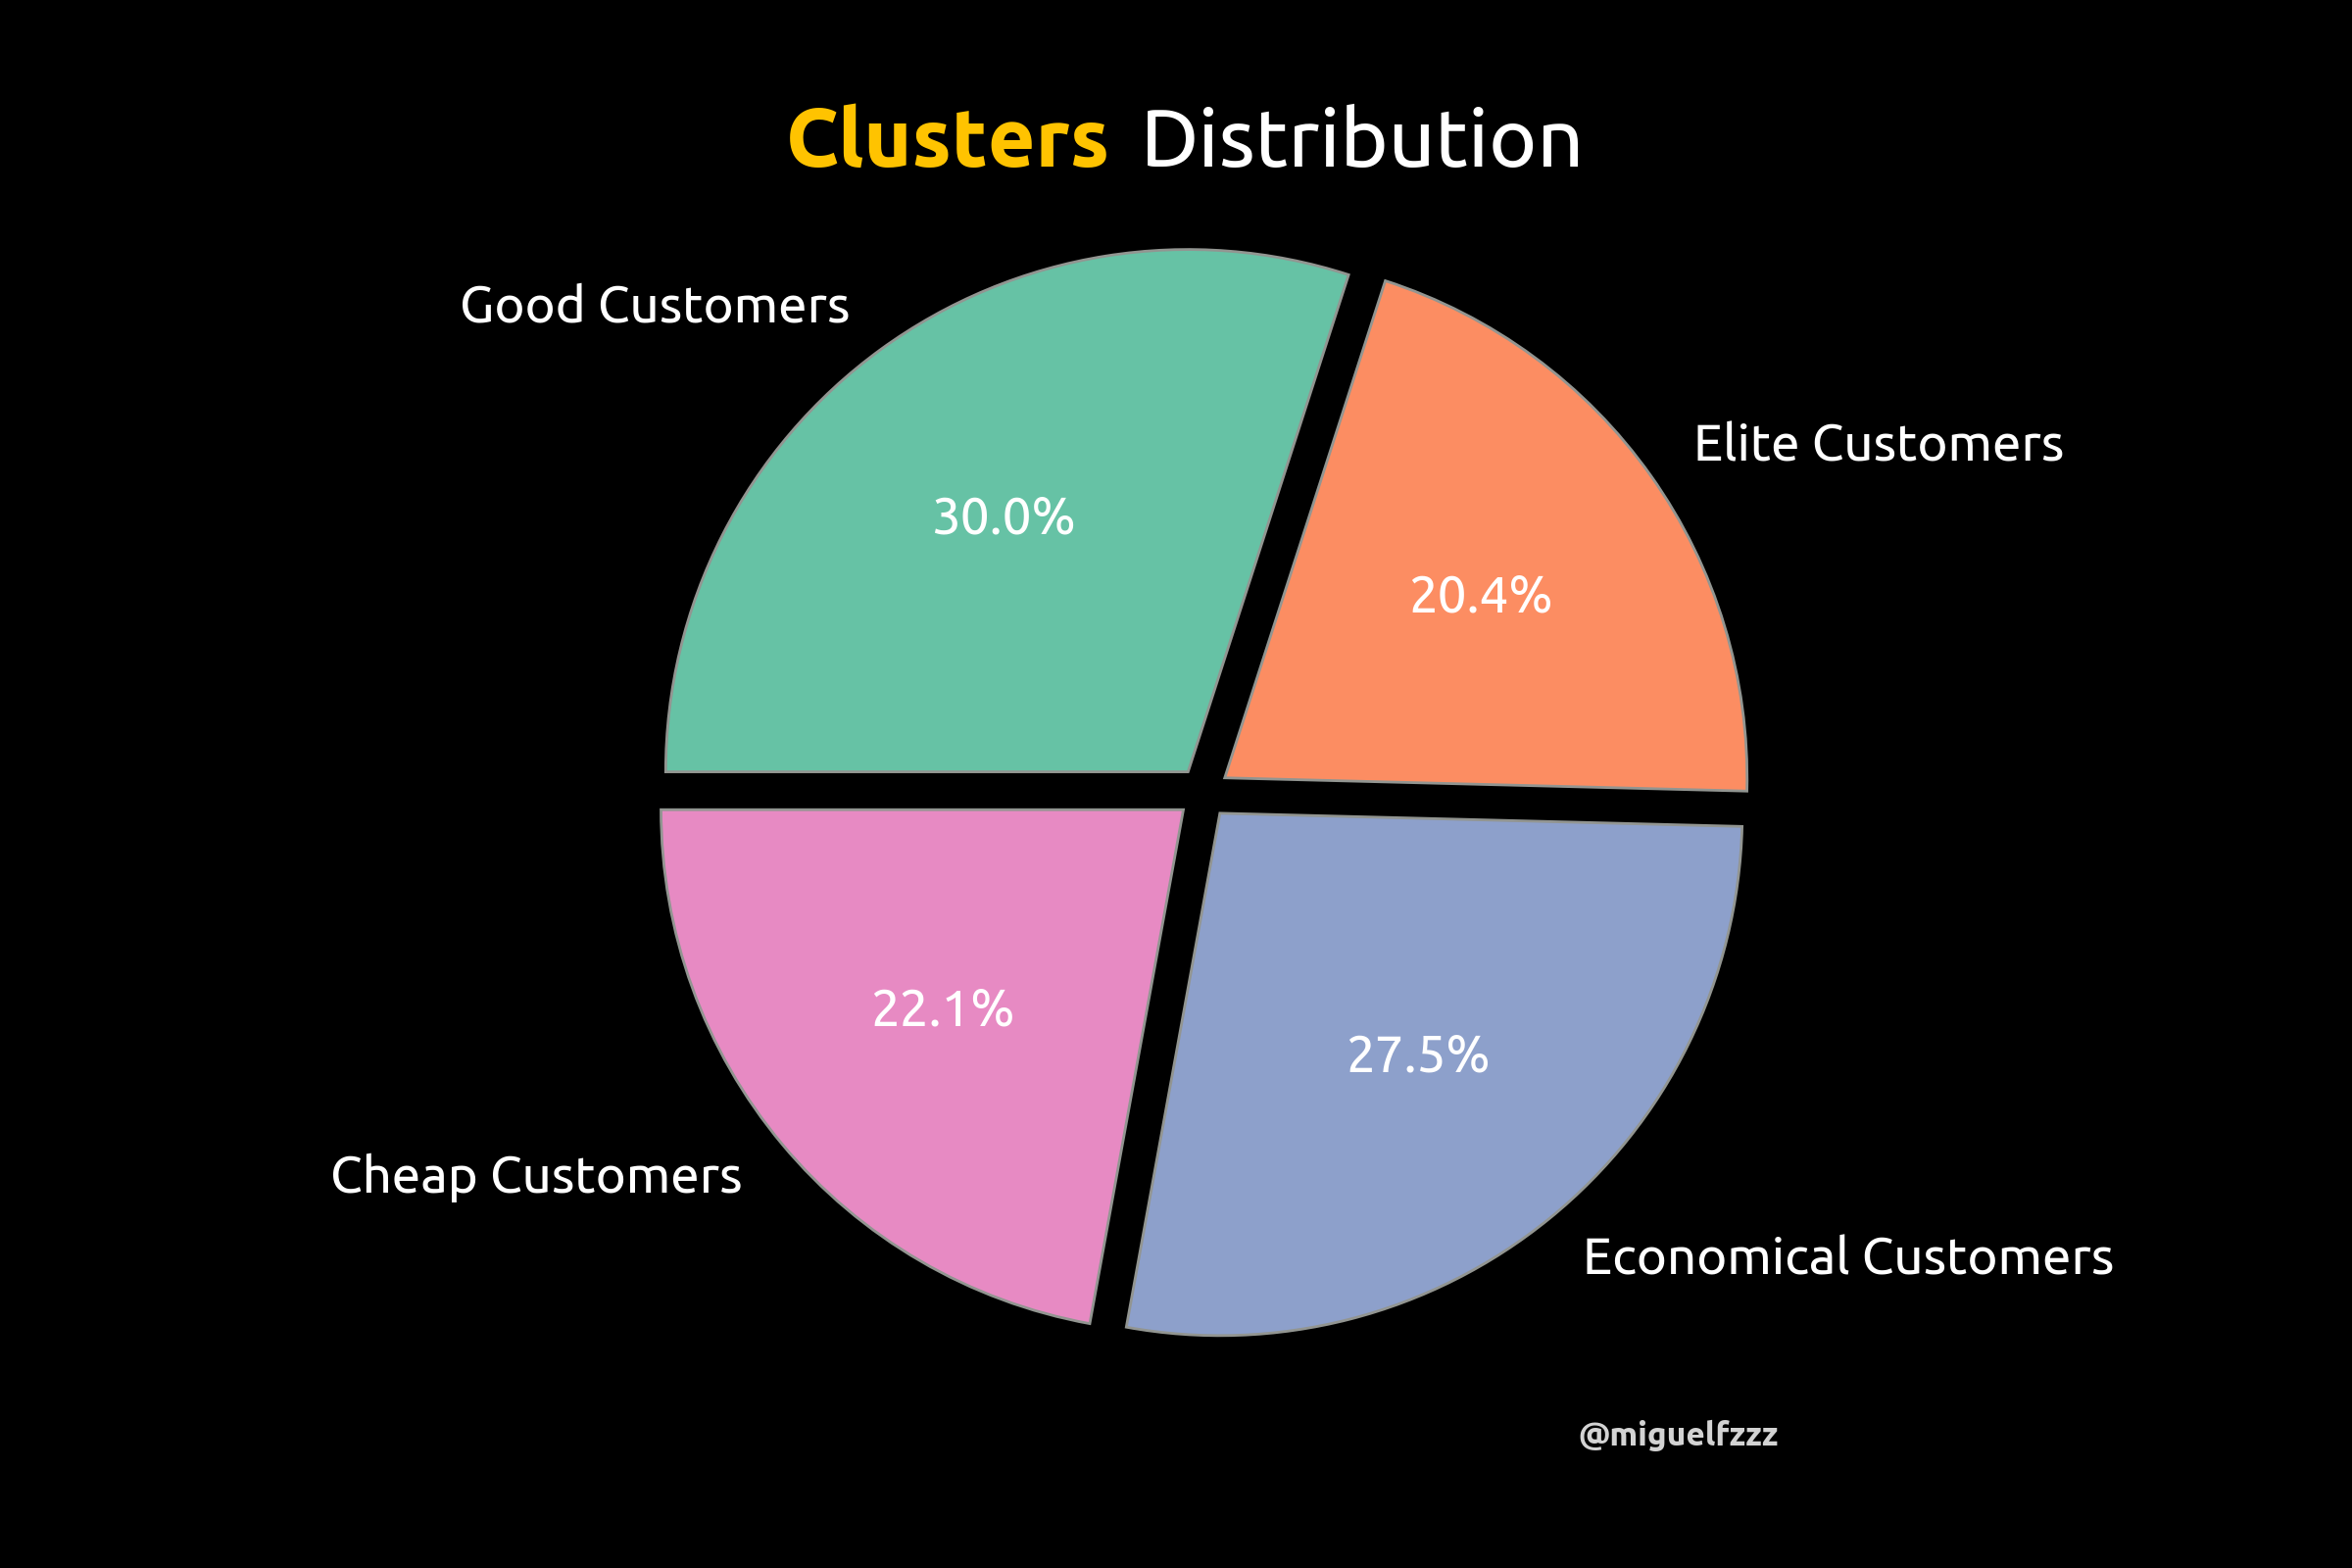

In [ ]:
# Results
clusters_count = df_clusters['cluster'].value_counts()                        # Counting wins-losses-draws
clusters_count = clusters_count.to_frame().reset_index()                      # Convert series to dataframe
clusters_count.columns = ['clusters', 'count']                                # Rename column names
clusters_count = clusters_count.sort_values('clusters', ascending = True)     # Sorting data

labels = [
        "Good Customers", 
        "Elite Customers", 
        "Economical Customers", 
        "Cheap Customers"
        ]

# Visualization
plt.figure(figsize=(12,8))

mpl.rcParams['font.size'] = 17
colors = sns.color_palette('Set2')[0:4]

plt.pie(clusters_count['count'], 
        explode=(0.05, 0.05, 0.05, 0.05), 
        labels = labels,
        colors= colors,
        autopct='%1.1f%%',
        textprops = dict(color ="white", fontsize=19),
        counterclock = False,
        startangle=180,
        wedgeprops={"edgecolor":"gray",'linewidth': 1}
        )

plt.axis('equal')

# Title 
plt.text(-0.8, 1.2, "Clusters", size=30, color="#FFC300", fontweight="bold")
plt.text(-0.12, 1.2, "Distribution", size=30, color="white")

# Author
plt.text(1.1, -1.25, "@miguelfzzz", fontsize=12, ha="right", color='lightgray', fontweight="bold")

plt.show()

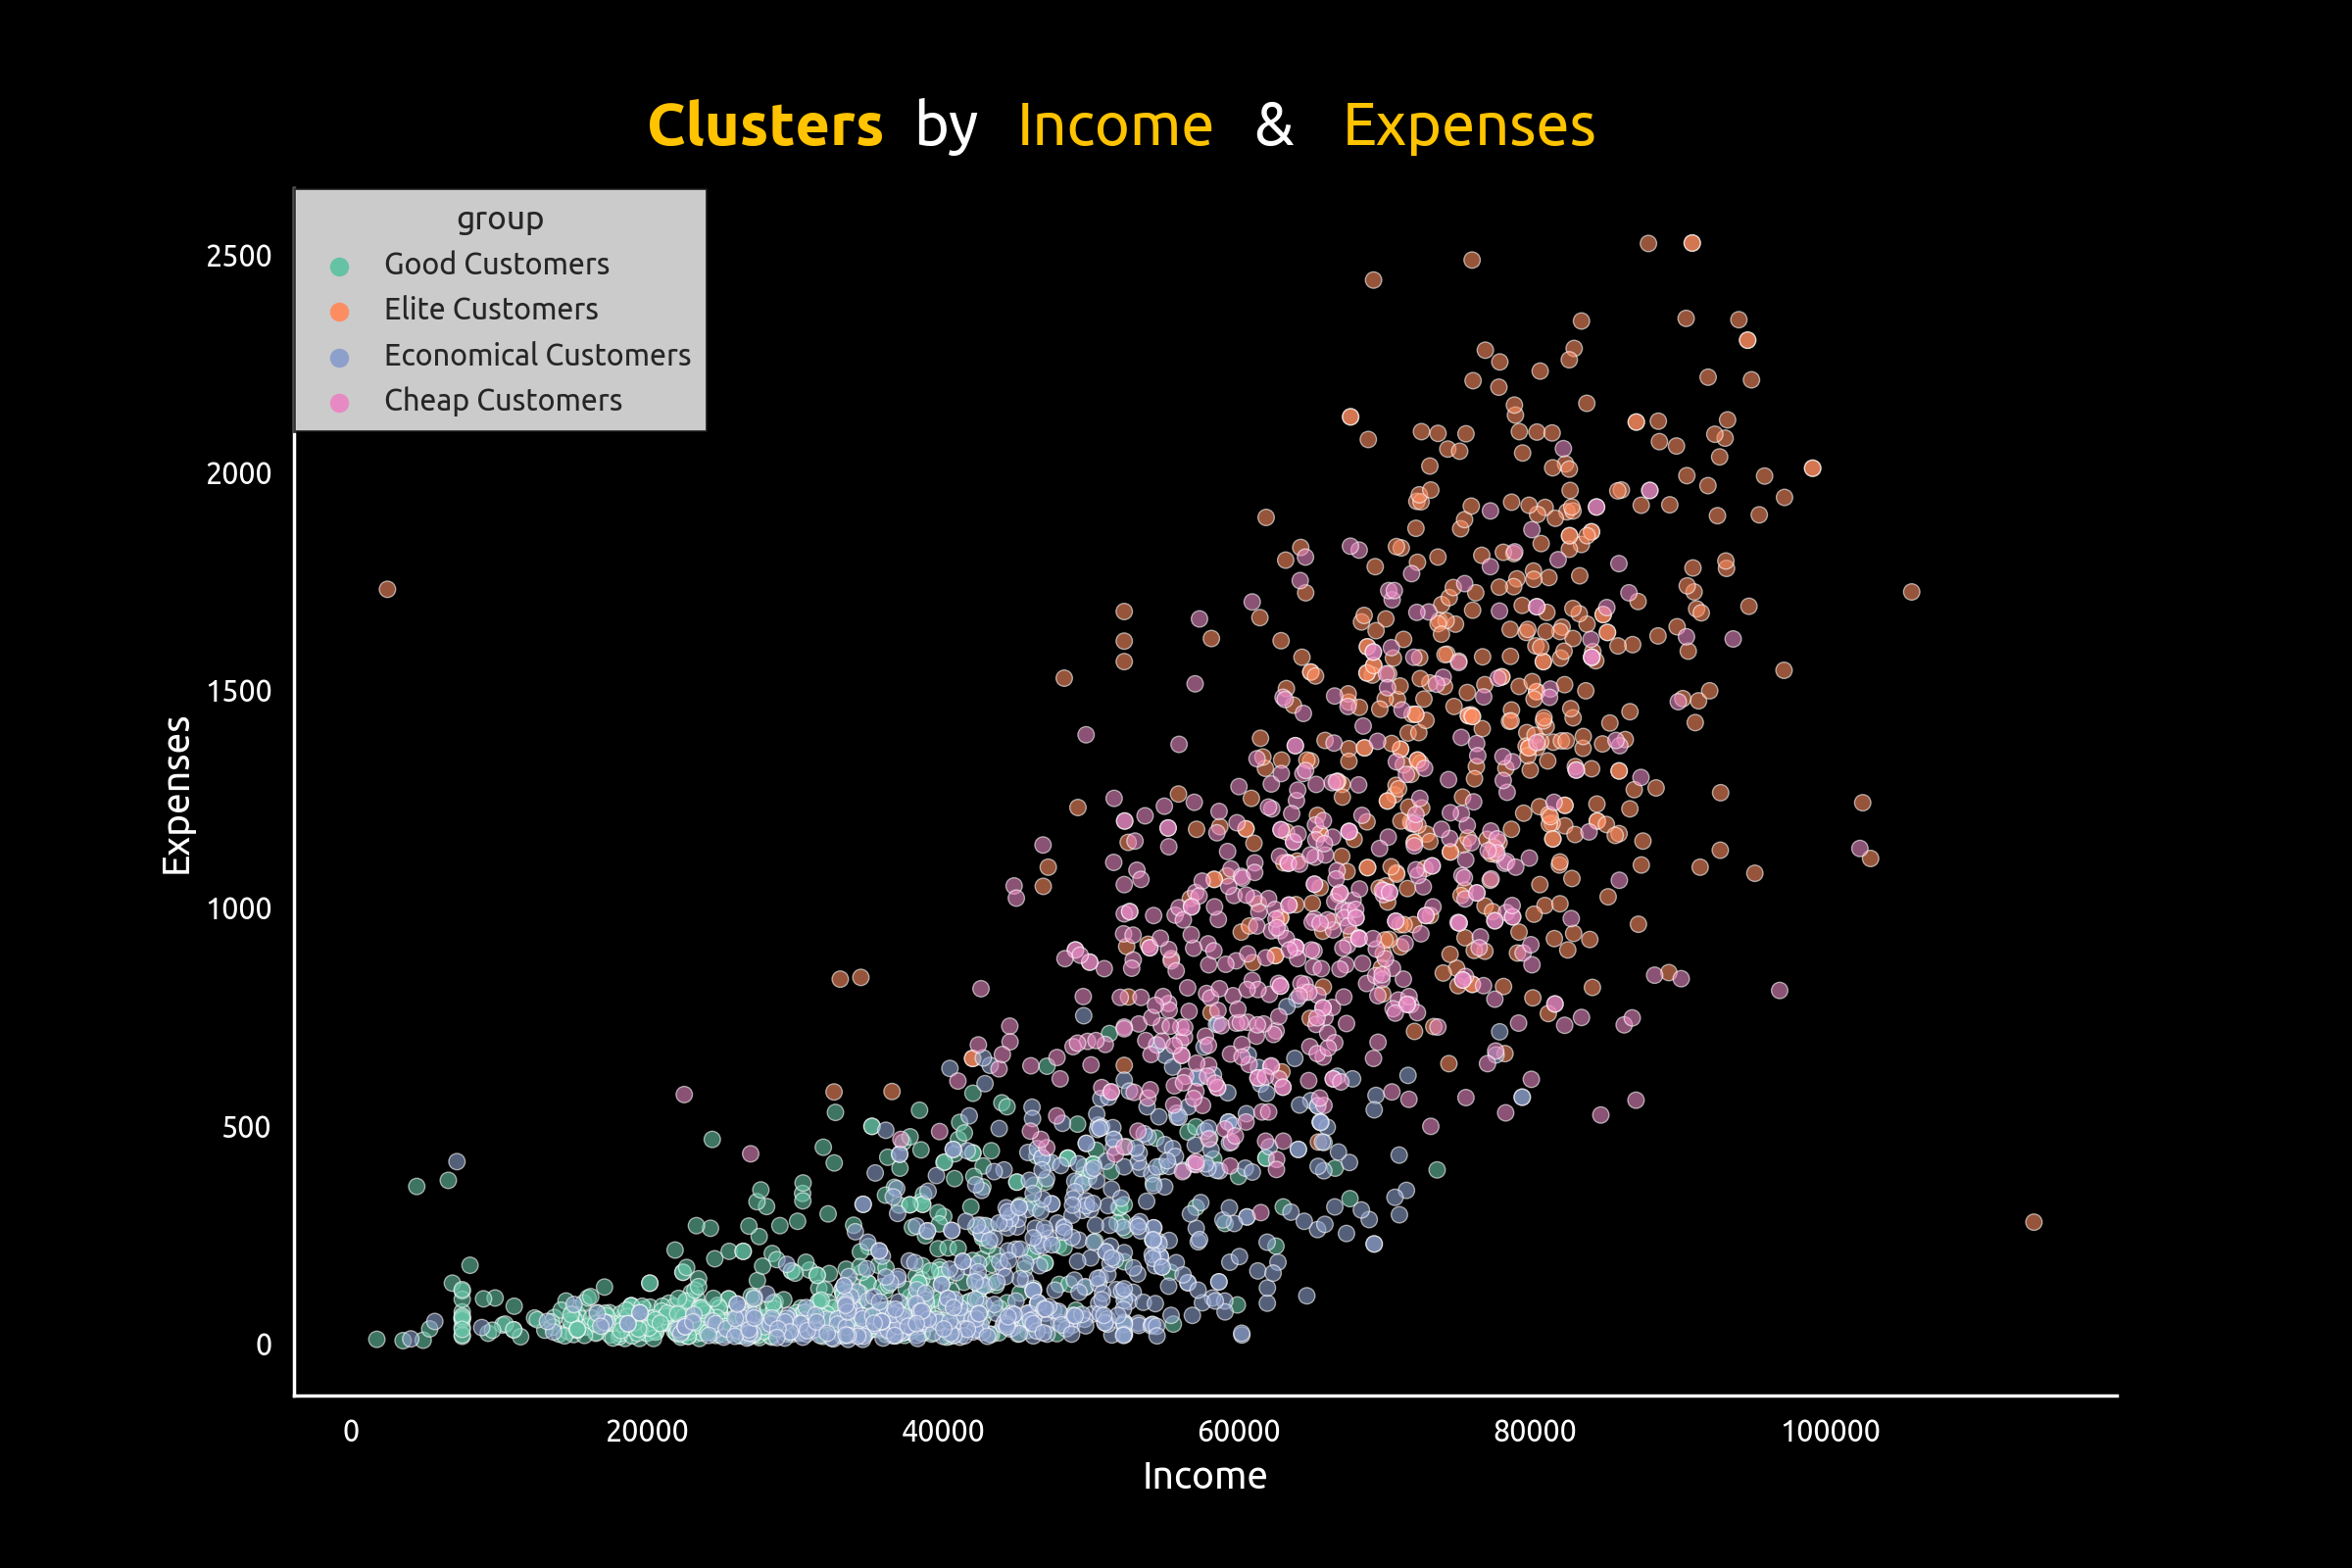

In [ ]:
# Creating a new dataset 
clusters_incomes = df_clusters[['Income', 'Expenses', 'cluster']]           # Select variables
clusters_incomes['group'] = clusters_incomes['cluster']                     # Create new variable
clusters_incomes['group'] = clusters_incomes['group'].astype(str)           # Change data type 

# Rename values
clusters_incomes['group'] = clusters_incomes['group'].str.replace('0', 'Good Customers')
clusters_incomes['group'] = clusters_incomes['group'].str.replace('1', 'Elite Customers')
clusters_incomes['group'] = clusters_incomes['group'].str.replace('2', 'Economical Customers')
clusters_incomes['group'] = clusters_incomes['group'].str.replace('3', 'Cheap Customers')

clusters_incomes = clusters_incomes.sort_values('group', ascending = False)    # Sorting data 

# Visualizing 
fig, ax = plt.subplots(figsize =(12, 8))

sns.scatterplot(data = clusters_incomes, x = 'Income', y = 'Expenses', hue = 'group', palette = 'Set2', alpha=0.6)

# Naming axis labels
plt.xlabel('Income', color = 'white', size = 14);
plt.ylabel('Expenses', color = 'white', size = 14);

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Coloring the axis in white
plt.tick_params(colors='white')

# Title
plt.text(20000, 2750, "Clusters", size=22, color="#FFC300", fontweight="bold")
plt.text(38000, 2750, "by", size=22, color="white")
plt.text(45000,2750,"Income", size=22, color="#FFC300")
plt.text(61000, 2750, "&", size=22, color="white")
plt.text(67000,2750,"Expenses", size=22, color="#FFC300")

# Author
# plt.text(120000, -350, "@miguelfzzz", fontsize=12, ha="right", color='lightgray', fontweight="bold")

plt.show()